# Installs & Imports

In [1]:
!pip install -q yfinance transformers optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.3 MB/s eta 0:00:00


In [2]:
!pip install -q git+https://github.com/IBM/tsfm.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import yfinance as yf
from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.exceptions import TrialPruned
from tqdm.auto import tqdm

from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
set_seed(123)

%matplotlib inline
sns.set(style="whitegrid")

# Load the Data

In [4]:
def fetch_data(ticker='^GSPC', start='2000-01-01', end='2024-10-22'):
    """
    Fetch historical data for the specified ticker.

    Args:
        ticker (str): Stock ticker symbol.
        start (str): Start date in 'YYYY-MM-DD' format.
        end (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame containing the 'Close' prices with a 'Date' column.
    """
    # Download data using yfinance
    data = yf.download(ticker, start=start, end=end)

    # Check if 'Close' column exists
    if 'Close' not in data.columns:
        raise ValueError("'Close' column not found in the downloaded data.")

    # Select only the 'Close' column
    data = data[['Close']].copy()

    # Reset index to make 'Date' a column
    data.reset_index(inplace=True)

    # Rename columns to ensure 'Date' and 'Close'
    data.columns = ['Date', 'Close']

    return data

In [5]:
# Fetch the data
data = fetch_data()
print("\n\nFirst ten rows of the data:")
display(data.head(10))
print("\nLast ten rows of the data:")
display(data.tail(10))

[*********************100%***********************]  1 of 1 completed



First ten rows of the data:


,Date,Close
0,2000-01-03 00:00:00+00:00,1455.219971
1,2000-01-04 00:00:00+00:00,1399.420044
2,2000-01-05 00:00:00+00:00,1402.109985
3,2000-01-06 00:00:00+00:00,1403.449951
4,2000-01-07 00:00:00+00:00,1441.469971
5,2000-01-10 00:00:00+00:00,1457.599976
6,2000-01-11 00:00:00+00:00,1438.560059
7,2000-01-12 00:00:00+00:00,1432.250000
8,2000-01-13 00:00:00+00:00,1449.680054
9,2000-01-14 00:00:00+00:00,1465.150024



Last ten rows of the data:


,Date,Close
6230,2024-10-08 00:00:00+00:00,5751.129883
6231,2024-10-09 00:00:00+00:00,5792.040039
6232,2024-10-10 00:00:00+00:00,5780.049805
6233,2024-10-11 00:00:00+00:00,5815.029785
6234,2024-10-14 00:00:00+00:00,5859.850098
6235,2024-10-15 00:00:00+00:00,5815.259766
6236,2024-10-16 00:00:00+00:00,5842.470215
6237,2024-10-17 00:00:00+00:00,5841.470215
6238,2024-10-18 00:00:00+00:00,5864.669922
6239,2024-10-21 00:00:00+00:00,5853.979980


In [6]:
def visualize_time_series(data):
    """
    Visualize the initial time series data.

    Args:
        data (pd.DataFrame): Time series data with 'Date' as a column and 'Close' as another column.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(data['Date'], data['Close'], label='Close Price')
    plt.title('S&P 500 Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

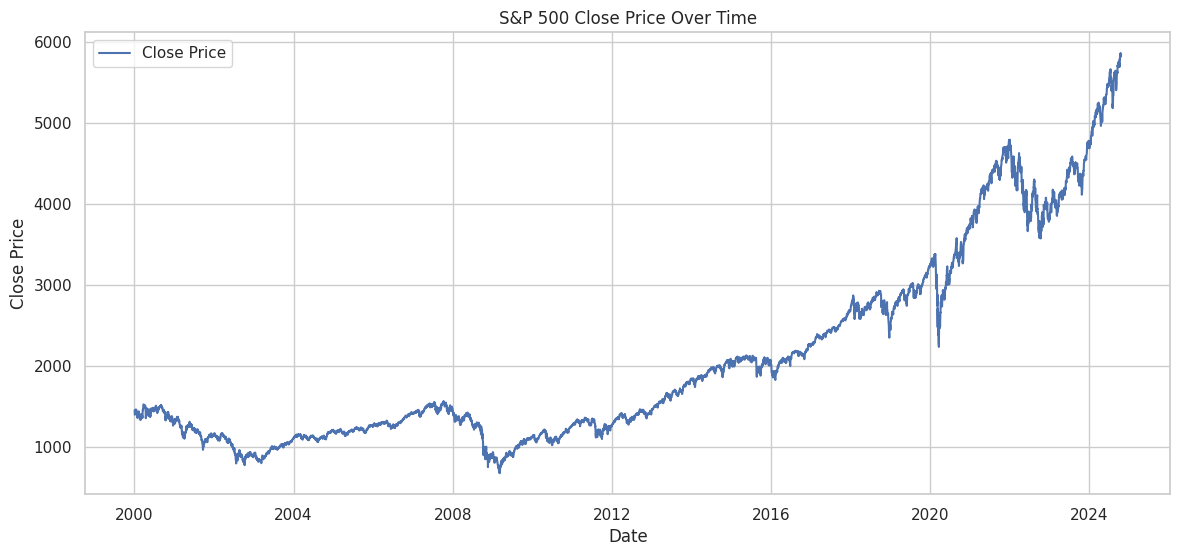

In [7]:
# Visualize the initial time series
visualize_time_series(data)

# Prepare the Data

In [8]:
def split_data(data, train_ratio=0.7, valid_ratio=0.2, context_length=60, forecast_horizon=1):
    """
    Split the data into training, validation, and testing sets.

    Args:
        data (pd.DataFrame): The complete dataset.
        train_ratio (float): Proportion of data to use for training.
        valid_ratio (float): Proportion of data to use for validation.
        context_length (int): Length of the input context.
        forecast_horizon (int): Length of the forecast horizon.

    Returns:
        tuple: (train_data, valid_data, test_data)
    """
    # Calculate the number of samples for each set
    num_train = int(len(data) * train_ratio)
    num_valid = int(len(data) * valid_ratio)
    num_test = len(data) - num_train - num_valid

    # Adjust indices based on context_length and forecast_horizon
    train_end = num_train
    valid_end = num_train + num_valid

    train_data = data.iloc[:train_end].reset_index(drop=True)
    valid_data = data.iloc[train_end:valid_end].reset_index(drop=True)
    test_data = data.iloc[valid_end:].reset_index(drop=True)

    return train_data, valid_data, test_data

In [9]:
# Split the data
context_length = 60
forecast_horizon = 1

train_data, valid_data, test_data = split_data(
    data,
    train_ratio=0.7,
    valid_ratio=0.15,
    context_length=context_length,
    forecast_horizon=forecast_horizon
)

# Verify shapes
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {valid_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (4368, 2)
Validation data shape: (936, 2)
Testing data shape: (936, 2)


In [10]:
def visualize_splits(train, valid, test):
    """
    Visualize the training, validation, and testing splits.

    Args:
        train (pd.DataFrame): Training data.
        valid (pd.DataFrame): Validation data.
        test (pd.DataFrame): Testing data.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(train['Date'], train['Close'], label='Training')
    plt.plot(valid['Date'], valid['Close'], label='Validation')
    plt.plot(test['Date'], test['Close'], label='Testing')
    plt.title('Data Splits')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

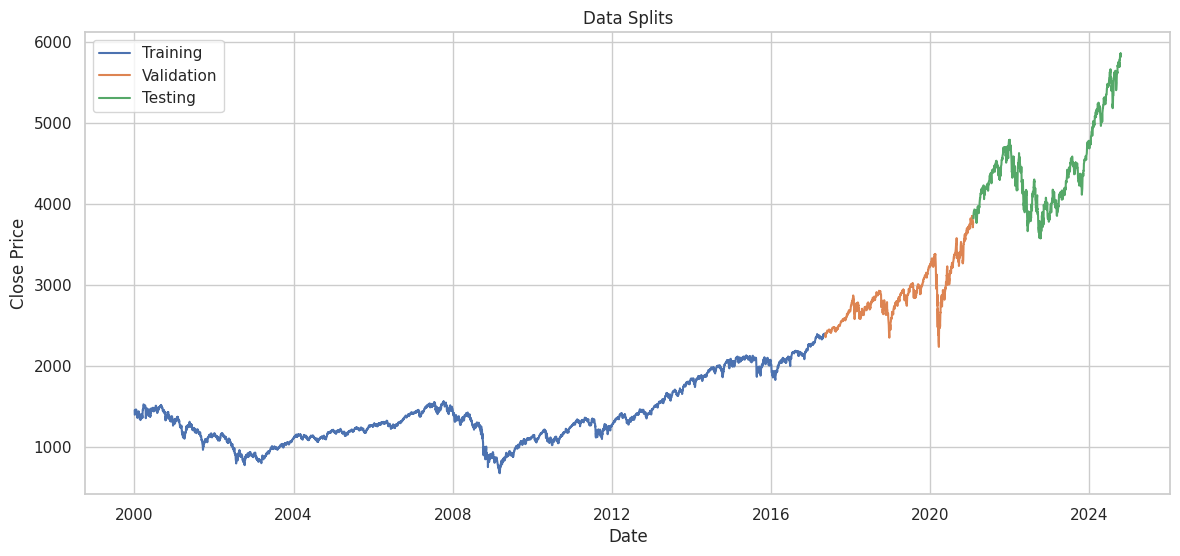

In [11]:
# Visualize the splits
visualize_splits(train_data, valid_data, test_data)

In [12]:
def preprocess_data(train, valid, test, timestamp_column='Date', forecast_columns=['Close']):
    """
    Preprocess the data: scaling and preparing for the model.

    Args:
        train (pd.DataFrame): Training data.
        valid (pd.DataFrame): Validation data.
        test (pd.DataFrame): Testing data.
        timestamp_column (str): Name of the timestamp column.
        forecast_columns (list): List of columns to forecast.

    Returns:
        tuple: (preprocessed_train, preprocessed_valid, preprocessed_test, preprocessor)
    """
    time_series_preprocessor = TimeSeriesPreprocessor(
        timestamp_column=timestamp_column,
        id_columns=[],
        input_columns=forecast_columns,
        output_columns=forecast_columns,
        scaling=True,
    )
    time_series_preprocessor = time_series_preprocessor.train(train)

    preprocessed_train = time_series_preprocessor.preprocess(train)
    preprocessed_valid = time_series_preprocessor.preprocess(valid)
    preprocessed_test = time_series_preprocessor.preprocess(test)

    return preprocessed_train, preprocessed_valid, preprocessed_test, time_series_preprocessor

In [13]:
# Preprocess the data
preprocessed_train, preprocessed_valid, preprocessed_test, preprocessor = preprocess_data(
    train_data,
    valid_data,
    test_data,
    timestamp_column='Date',
    forecast_columns=['Close']
)

In [14]:
# Verify preprocessing by displaying head of preprocessed data
print("First five rows of the preprocessed training data:")
display(preprocessed_train.head(5))
print("\nFirst five rows of the preprocessed validation data:")
display(preprocessed_valid.head(5))
print("\nFirst five rows of the preprocessed testing data:")
display(preprocessed_test.head(5))

First five rows of the preprocessed training data:


,Date,Close
0,2000-01-03 00:00:00+00:00,0.153900
1,2000-01-04 00:00:00+00:00,0.008364
2,2000-01-05 00:00:00+00:00,0.015379
3,2000-01-06 00:00:00+00:00,0.018874
4,2000-01-07 00:00:00+00:00,0.118037



First five rows of the preprocessed validation data:


,Date,Close
0,2017-05-15 00:00:00+00:00,2.624107
1,2017-05-16 00:00:00+00:00,2.619803
2,2017-05-17 00:00:00+00:00,2.505982
3,2017-05-18 00:00:00+00:00,2.528647
4,2017-05-19 00:00:00+00:00,2.570404



First five rows of the preprocessed testing data:


,Date,Close
0,2021-02-02 00:00:00+00:00,6.338129
1,2021-02-03 00:00:00+00:00,6.348196
2,2021-02-04 00:00:00+00:00,6.456618
3,2021-02-05 00:00:00+00:00,6.495976
4,2021-02-08 00:00:00+00:00,6.570987


In [15]:
def create_datasets(preprocessed_train, preprocessed_valid, preprocessed_test, forecast_columns=['Close'],
                   context_length=60, forecast_horizon=1):
    """
    Create ForecastDFDataset instances for training, validation, and testing.

    Args:
        preprocessed_train (pd.DataFrame): Preprocessed training data.
        preprocessed_valid (pd.DataFrame): Preprocessed validation data.
        preprocessed_test (pd.DataFrame): Preprocessed testing data.
        forecast_columns (list): List of columns to forecast.
        context_length (int): Length of the input context.
        forecast_horizon (int): Length of the forecast horizon.

    Returns:
        tuple: (train_dataset, valid_dataset, test_dataset)
    """
    # Create training dataset
    train_dataset = ForecastDFDataset(
        data=preprocessed_train,
        id_columns=[],
        timestamp_column='Date',
        target_columns=forecast_columns,
        observable_columns=[],
        control_columns=[],
        conditional_columns=[],
        static_categorical_columns=[],
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    # Create validation dataset
    valid_dataset = ForecastDFDataset(
        data=preprocessed_valid,
        id_columns=[],
        timestamp_column='Date',
        target_columns=forecast_columns,
        observable_columns=[],
        control_columns=[],
        conditional_columns=[],
        static_categorical_columns=[],
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    test_dataset = ForecastDFDataset(
        data=preprocessed_test,
        id_columns=[],
        timestamp_column='Date',
        target_columns=forecast_columns,
        observable_columns=[],
        control_columns=[],
        conditional_columns=[],
        static_categorical_columns=[],
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    return train_dataset, valid_dataset, test_dataset

In [16]:
# Create datasets
train_dataset, valid_dataset, test_dataset = create_datasets(
    preprocessed_train,
    preprocessed_valid,
    preprocessed_test,
    forecast_columns=['Close'],
    context_length=context_length,
    forecast_horizon=forecast_horizon
)

# Verify dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 4308
Validation dataset size: 876
Testing dataset size: 876


# Model & Training

In [17]:
def configure_model(num_input_channels=1, context_length=60, patch_length=16, forecast_horizon=1,
                   d_model=128, num_attention_heads=16, num_hidden_layers=3, ffn_dim=256, dropout=0.2,
                   head_dropout=0.2, random_mask_ratio=0.4):
    """
    Configure the PatchTST model.

    Args:
        num_input_channels (int): Number of input channels.
        context_length (int): Length of the input context.
        patch_length (int): Length of each patch.
        forecast_horizon (int): Length of the forecast horizon.
        d_model (int): Dimension of the model.
        num_attention_heads (int): Number of attention heads.
        num_hidden_layers (int): Number of hidden layers.
        ffn_dim (int): Dimension of the feedforward network.
        dropout (float): Dropout rate.
        head_dropout (float): Dropout rate for the head.
        random_mask_ratio (float): Ratio for random masking.

    Returns:
        PatchTSTForPrediction: Configured PatchTST model.
    """
    config = PatchTSTConfig(
        num_input_channels=num_input_channels,
        context_length=context_length,
        patch_length=patch_length,
        patch_stride=patch_length,
        prediction_length=forecast_horizon,
        random_mask_ratio=random_mask_ratio,
        d_model=d_model,
        num_attention_heads=num_attention_heads,
        num_hidden_layers=num_hidden_layers,
        ffn_dim=ffn_dim,
        dropout=dropout,
        head_dropout=head_dropout,
        pooling_type=None,
        channel_attention=False,
        scaling="std",
        loss="mse",
        pre_norm=True,
        norm_type="batchnorm",
    )
    model = PatchTSTForPrediction(config)
    return model

In [18]:
# Configure the model
model = configure_model(
    num_input_channels=1,
    context_length=context_length,
    patch_length=16,
    forecast_horizon=forecast_horizon
)

# Verify model configuration
print(model.config)

PatchTSTConfig {
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 60,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.2,
  "ff_dropout": 0.0,
  "ffn_dim": 256,
  "head_dropout": 0.2,
  "init_std": 0.02,
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 16,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 1,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_length": 16,
  "patch_stride": 16,
  "path_dropout": 0.0,
  "pooling_type": null,
  "positional_dropout": 0.0,
  "positional_encoding_type": "sincos",
  "pre_norm": true,
  "prediction_length": 1,
  "random_mask_ratio": 0.4,
  "scaling": "std",
  "share_embedding": true,
  "share_pro

In [19]:
def train_model(model, train_dataset, valid_dataset, output_dir='./checkpoint/patchtst/sp500/pretrain/output/',
               logging_dir='./checkpoint/patchtst/sp500/pretrain/logs/', batch_size=64, num_workers=16,
               num_epochs=100, learning_rate=0.001, early_stopping_patience=10, early_stopping_threshold=0.0001):
    """
    Train the PatchTST model.

    Args:
        model (PatchTSTForPrediction): The PatchTST model.
        train_dataset (ForecastDFDataset): Training dataset.
        valid_dataset (ForecastDFDataset): Validation dataset.
        output_dir (str): Directory to save checkpoints.
        logging_dir (str): Directory for logging.
        batch_size (int): Batch size.
        num_workers (int): Number of worker threads.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.
        early_stopping_patience (int): Patience for early stopping.
        early_stopping_threshold (float): Threshold for early stopping.

    Returns:
        Trainer: Trained Trainer instance.
    """
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=num_workers,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir=logging_dir,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        label_names=["future_values"],
        report_to="none",  # Disable wandb and other integrations
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=early_stopping_patience,
        early_stopping_threshold=early_stopping_threshold,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping_callback],
    )

    # Start training
    trainer.train()

    return trainer

In [20]:
# Train the model
trainer = train_model(
    model,
    train_dataset,
    valid_dataset,
    output_dir='./checkpoint/patchtst/sp500/pretrain/output/',
    logging_dir='./checkpoint/patchtst/sp500/pretrain/logs/',
    batch_size=64,
    num_workers=16,
    num_epochs=100
)

Epoch,Training Loss,Validation Loss
1,0.003100,0.011121
2,0.002100,0.043825
3,0.002100,0.011049
4,0.001900,0.016950
5,0.001800,0.011919
6,0.001700,0.017966
7,0.001900,0.011729
8,0.001800,0.017767
9,0.001900,0.012962
10,0.001700,0.010765


In [21]:
def save_model(trainer, save_dir='patchtst/sp500/final_model/'):
    """
    Save the trained model.

    Args:
        trainer (Trainer): Trained Trainer instance.
        save_dir (str): Directory to save the model.
    """
    os.makedirs(save_dir, exist_ok=True)
    trainer.save_model(save_dir)

In [22]:
# Save the trained model
save_model(trainer, save_dir='patchtst/sp500/model/pretrain/')

# Evaluate the Model

In [23]:
def evaluate_model(trainer, test_dataset):
    """
    Evaluate the model on the test dataset.

    Args:
        trainer (Trainer): Trained Trainer instance.
        test_dataset (ForecastDFDataset): Testing dataset.

    Returns:
        dict: Evaluation results.
    """
    results = trainer.evaluate(test_dataset)
    return results

In [24]:
# Evaluate the model
results = evaluate_model(trainer, test_dataset)
print("Test result:")
for key, value in results.items():
    print(f"  {key}: {value}")

Test result:
  eval_loss: 0.016794027760624886
  eval_runtime: 0.6018
  eval_samples_per_second: 1455.683
  eval_steps_per_second: 23.264
  epoch: 29.0


In [25]:
def get_predictions(trainer, test_dataset, test_data, train_data, context_length=60):
    """
    Extract and inverse-transform actual and predicted values from the test dataset.

    Args:
        trainer (Trainer): Trained Trainer instance.
        test_dataset (ForecastDFDataset): Testing dataset.
        test_data (pd.DataFrame): Original test data (not preprocessed).
        train_data (pd.DataFrame): Original training data (not preprocessed).
        context_length (int): Length of the input context.

    Returns:
        tuple: (actual_paired, predicted_original) as 1D numpy arrays in original scale.
    """
    # Run prediction
    predictions_output = trainer.predict(test_dataset)

    # Extract predictions
    # Handle both namedtuple and tuple outputs
    if hasattr(predictions_output, 'predictions'):
        predictions = predictions_output.predictions
    else:
        predictions = predictions_output[0]  # First element is predictions

    # If predictions is still a tuple (e.g., (predictions, label_ids, metrics)), extract the first element
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Ensure predictions are in a numpy array format
    if not isinstance(predictions, np.ndarray):
        predictions = np.array(predictions)

    # If predictions have extra dimensions, flatten them
    if predictions.ndim > 1:
        predictions = predictions.squeeze()

    # Compute mean and std of training data 'Close' for inverse scaling
    mean = train_data['Close'].values[context_length:].mean()  # Exclude the first 60 points
    std = train_data['Close'].values[context_length:].std()  # Exclude the first 60 points

    # Inverse transform predictions
    predicted_original = predictions * std + mean

    # Extract actual values from test_data
    # Since test_dataset includes the last `context_length` from validation as context,
    # predictions start after these `context_length` data points
    actual_paired = test_data['Close'].values[context_length:]  # Exclude the first 60 points

    # Verify alignment
    if len(predicted_original) != len(actual_paired):
        raise ValueError(f"Number of predictions ({len(predicted_original)}) does not match number of actual values ({len(actual_paired)}).")

    return actual_paired, predicted_original

In [26]:
# Get actual and predicted values
actual, predicted = get_predictions(
    trainer,
    test_dataset,
    test_data,
    train_data,
    context_length=context_length
)

# Verify shapes
print(f"Actual shape: {actual.shape}")
print(f"Predicted shape: {predicted.shape}")

Actual shape: (876,)
Predicted shape: (876,)


In [27]:
def compute_evaluation_metrics(actual, predicted):
    """
    Compute evaluation metrics: MSE, RMSE, MAE, MAPE, MASE.

    Args:
        actual (np.array): Actual values, shape (num_samples,)
        predicted (np.array): Predicted values, shape (num_samples,)

    Returns:
        dict: Dictionary containing computed metrics.
    """
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    # Handle division by zero in MAPE
    epsilon = 1e-10
    mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

    # Compute MASE
    # Calculate the mean absolute error of the in-sample one-step naive forecast
    n = len(actual)
    if n < 2:
        mase = None
    else:
        scale = np.mean(np.abs(np.diff(actual)))
        mase = mae / scale if scale != 0 else None

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MASE': mase
    }
    return metrics

In [28]:
# Compute evaluation metrics
metrics = compute_evaluation_metrics(actual, predicted)

In [29]:
def create_metrics_df(metrics_dict):
    """
    Create a DataFrame from the metrics dictionary.

    Args:
        metrics_dict (dict): Dictionary containing metrics.

    Returns:
        pd.DataFrame: DataFrame with metrics.
    """
    df = pd.DataFrame([metrics_dict])
    df.index = ['Scores']
    return df

In [30]:
# Create metrics DataFrame
metrics_df = create_metrics_df(metrics)

# Transpose the DataFrame
metrics_df = metrics_df.T
metrics_df.columns = ['Scores']

print("Evaluation Metrics:")
display(metrics_df)

Evaluation Metrics:


,Scores
MSE,2694.758233
RMSE,51.911061
MAE,38.702189
MAPE,0.888248
MASE,1.128812


In [31]:
def visualize_metrics(metrics_df):
    """
    Visualize RMSE and MAE metrics in a bar chart.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing evaluation metrics.
    """
    metrics = metrics_df.loc[['RMSE', 'MAE'], 'Scores']
    metrics.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'salmon'])
    plt.ylim(0, metrics.max() * 1.3)
    plt.title('RMSE and MAE Metrics')
    plt.ylabel('Error')
    plt.xticks(rotation=0)
    plt.show()

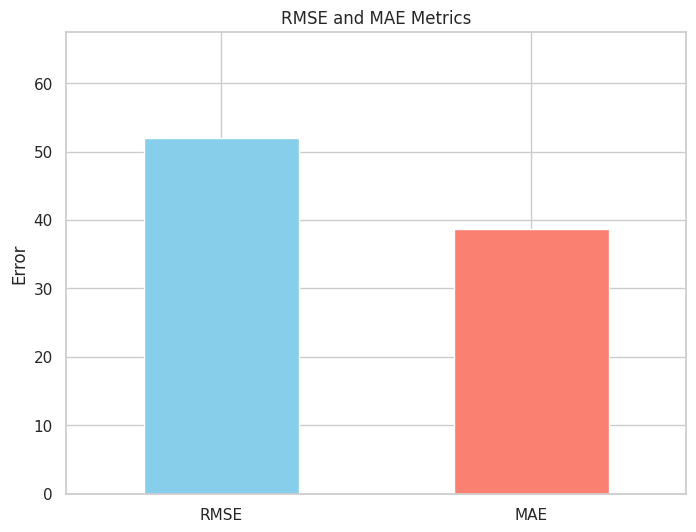

In [32]:
# Visualize metrics
visualize_metrics(metrics_df)

In [33]:
def visualize_actual_vs_predicted(actual, predicted, title='Actual vs. Predicted Close Prices', num_points=500):
    """
    Visualize actual vs. predicted values for the test set.

    Args:
        actual (np.array): Actual values, shape (num_samples,)
        predicted (np.array): Predicted values, shape (num_samples,)
        title (str): Title of the plot.
        num_points (int): Number of data points to plot for clarity.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(actual[:num_points], label='Actual', color='blue')
    plt.plot(predicted[:num_points], label='Predicted', color='orange', linestyle='--')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

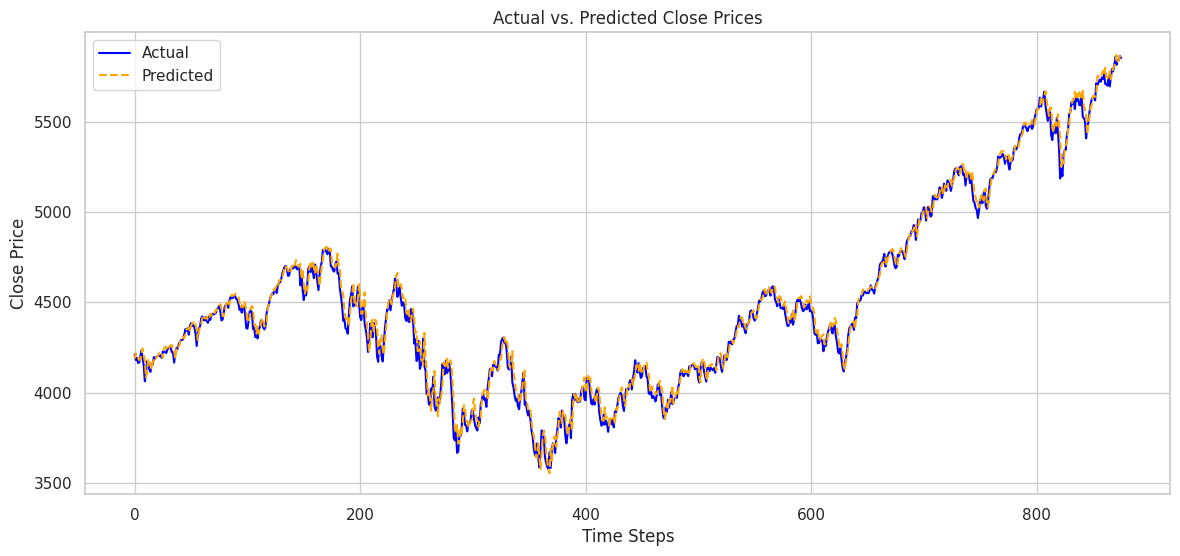

In [34]:
# Visualize actual vs. predicted values
num_points = len(test_data)
visualize_actual_vs_predicted(
    actual,
    predicted,
    title='Actual vs. Predicted Close Prices',
    num_points=num_points
)

# Hyperparameter Tuning

In [35]:
def objective(trial, data, forecast_columns=['Close'], context_length=60, forecast_horizon=1, n_splits=5):
    """
    Objective function for Optuna hyperparameter tuning.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        data (pd.DataFrame): The complete dataset.
        forecast_columns (list): List of columns to forecast.
        context_length (int): Length of the input context.
        forecast_horizon (int): Length of the forecast horizon.
        n_splits (int): Number of cross-validation splits.

    Returns:
        float: Mean validation loss across splits.
    """
    # Define hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [4, 8, 16])
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 4)
    ffn_dim = trial.suggest_categorical('ffn_dim', [128, 256, 512])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    head_dropout = trial.suggest_float('head_dropout', 0.1, 0.5)
    random_mask_ratio = trial.suggest_float('random_mask_ratio', 0.2, 0.6)

    # Initialize cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    val_losses = []

    for fold, (train_idx, valid_idx) in enumerate(tscv.split(data)):
        print(f"Starting Fold {fold + 1}/{n_splits}...")

        # Split data
        train_fold = data.iloc[train_idx].reset_index(drop=True)
        valid_fold = data.iloc[valid_idx].reset_index(drop=True)

        # Preprocess data
        preprocessed_train, preprocessed_valid, _, _ = preprocess_data(
            train=train_fold,
            valid=valid_fold,
            test=valid_fold,  # Test can be same as valid or handled differently
            timestamp_column='Date',
            forecast_columns=forecast_columns
        )

        # Create datasets
        train_dataset_fold = ForecastDFDataset(
            data=preprocessed_train,
            id_columns=[],
            timestamp_column='Date',
            target_columns=forecast_columns,
            observable_columns=[],
            control_columns=[],
            conditional_columns=[],
            static_categorical_columns=[],
            context_length=context_length,
            prediction_length=forecast_horizon,
        )
        valid_dataset_fold = ForecastDFDataset(
            data=preprocessed_valid,
            id_columns=[],
            timestamp_column='Date',
            target_columns=forecast_columns,
            observable_columns=[],
            control_columns=[],
            conditional_columns=[],
            static_categorical_columns=[],
            context_length=context_length,
            prediction_length=forecast_horizon,
        )

        # Configure model with hyperparameters for this fold
        model_fold = configure_model(
            num_input_channels=1,
            context_length=context_length,
            patch_length=16,
            forecast_horizon=forecast_horizon,
            d_model=d_model,
            num_attention_heads=num_attention_heads,
            num_hidden_layers=num_hidden_layers,
            ffn_dim=ffn_dim,
            dropout=dropout,
            head_dropout=head_dropout,
            random_mask_ratio=random_mask_ratio
        )

        # Define training arguments
        training_args = TrainingArguments(
            output_dir=f'./optuna_fold_{fold}',  # Unique directory for each fold
            overwrite_output_dir=True,
            learning_rate=learning_rate,
            num_train_epochs=10,
            do_eval=True,
            evaluation_strategy="epoch",
            save_strategy="epoch",  # Changed from "no" to "epoch" to align with eval strategy
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            dataloader_num_workers=4,
            logging_strategy="epoch",
            disable_tqdm=True,
            load_best_model_at_end=True,
            save_total_limit=1,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            label_names=["future_values"],
            report_to="none",
        )

        # Initialize Trainer
        trainer = Trainer(
            model=model_fold,
            args=training_args,
            train_dataset=train_dataset_fold,
            eval_dataset=valid_dataset_fold,
            callbacks=[],  # No callbacks needed
        )

        # Train model
        trainer.train()

        # Evaluate
        results = trainer.evaluate(valid_dataset_fold)
        val_loss = results['eval_loss']
        val_losses.append(val_loss)
        print(f"Fold {fold + 1} Validation Loss: {val_loss}")

        # Report intermediate objective value
        trial.report(val_loss, fold)

        # Handle pruning
        if trial.should_prune():
            raise TrialPruned()

    # Return the average validation loss
    mean_val_loss = np.mean(val_losses)
    print(f"Mean Validation Loss: {mean_val_loss}")
    return mean_val_loss

In [36]:
def run_hyperparameter_tuning(data, forecast_columns=['Close'], context_length=60, forecast_horizon=1,
                              n_trials=50, n_splits=5):
    """
    Run hyperparameter tuning using Optuna.

    Args:
        data (pd.DataFrame): The complete dataset.
        forecast_columns (list): List of columns to forecast.
        context_length (int): Length of the input context.
        forecast_horizon (int): Length of the forecast horizon.
        n_trials (int): Number of Optuna trials.
        n_splits (int): Number of cross-validation splits.

    Returns:
        optuna.study.Study: The completed Optuna study.
    """
    study = optuna.create_study(direction='minimize', study_name='PatchTST Hyperparameter Tuning')
    study.optimize(lambda trial: objective(trial, data, forecast_columns, context_length, forecast_horizon, n_splits),
                  n_trials=n_trials,
                  timeout=None)
    return study

In [37]:
# Run hyperparameter tuning
print("Starting Hyperparameter Tuning with Optuna...")
study = run_hyperparameter_tuning(
    data,
    forecast_columns=['Close'],
    context_length=context_length,
    forecast_horizon=forecast_horizon,
    n_trials=50,
    n_splits=5
)
print("\nHyperparameter Tuning Completed.")
print("Best Trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-10-25 08:21:59,978] A new study created in memory with name: PatchTST Hyperparameter Tuning


Starting Hyperparameter Tuning with Optuna...
Starting Fold 1/5...
{'loss': 0.0278, 'grad_norm': 0.6031666994094849, 'learning_rate': 5.293512602128017e-05, 'epoch': 1.0}
{'eval_loss': 0.023081045597791672, 'eval_runtime': 0.3215, 'eval_samples_per_second': 3048.39, 'eval_steps_per_second': 96.429, 'epoch': 1.0}
{'loss': 0.013, 'grad_norm': 0.15862809121608734, 'learning_rate': 4.705344535224904e-05, 'epoch': 2.0}
{'eval_loss': 0.006624578032642603, 'eval_runtime': 0.3386, 'eval_samples_per_second': 2894.143, 'eval_steps_per_second': 91.549, 'epoch': 2.0}
{'loss': 0.0099, 'grad_norm': 0.22002017498016357, 'learning_rate': 4.1171764683217906e-05, 'epoch': 3.0}
{'eval_loss': 0.004726941231638193, 'eval_runtime': 0.3044, 'eval_samples_per_second': 3219.655, 'eval_steps_per_second': 101.846, 'epoch': 3.0}
{'loss': 0.0082, 'grad_norm': 0.1833517700433731, 'learning_rate': 3.529008401418678e-05, 'epoch': 4.0}
{'eval_loss': 0.004208775237202644, 'eval_runtime': 0.3078, 'eval_samples_per_secon

[I 2024-10-25 08:23:39,570] Trial 0 finished with value: 0.007687966665253043 and parameters: {'learning_rate': 5.88168066903113e-05, 'd_model': 256, 'num_attention_heads': 8, 'num_hidden_layers': 3, 'ffn_dim': 128, 'dropout': 0.29715340633467957, 'head_dropout': 0.2288851182556615, 'random_mask_ratio': 0.330194017800748}. Best is trial 0 with value: 0.007687966665253043.


{'eval_loss': 0.005638343747705221, 'eval_runtime': 0.3422, 'eval_samples_per_second': 2864.201, 'eval_steps_per_second': 90.602, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005638343747705221
Mean Validation Loss: 0.007687966665253043
Starting Fold 1/5...
{'loss': 0.0216, 'grad_norm': 0.5256935358047485, 'learning_rate': 8.681149711006498e-05, 'epoch': 1.0}
{'eval_loss': 0.020463483408093452, 'eval_runtime': 0.3368, 'eval_samples_per_second': 2910.168, 'eval_steps_per_second': 92.056, 'epoch': 1.0}
{'loss': 0.011, 'grad_norm': 0.1739603877067566, 'learning_rate': 7.716577520894665e-05, 'epoch': 2.0}
{'eval_loss': 0.004605398979038, 'eval_runtime': 0.3373, 'eval_samples_per_second': 2905.624, 'eval_steps_per_second': 91.913, 'epoch': 2.0}
{'loss': 0.0098, 'grad_norm': 0.19494423270225525, 'learning_rate': 6.752005330782832e-05, 'epoch': 3.0}
{'eval_loss': 0.004901675973087549, 'eval_runtime': 0.3105, 'eval_samples_per_second': 3156.247, 'eval_steps_per_second': 99.84, 'epoch': 3.0}
{'loss

[I 2024-10-25 08:25:19,243] Trial 1 finished with value: 0.007602936308830977 and parameters: {'learning_rate': 9.645721901118331e-05, 'd_model': 256, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.1392396838167076, 'head_dropout': 0.44973007643147833, 'random_mask_ratio': 0.3018950628393378}. Best is trial 1 with value: 0.007602936308830977.


{'eval_loss': 0.005770671181380749, 'eval_runtime': 0.3141, 'eval_samples_per_second': 3120.269, 'eval_steps_per_second': 98.702, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005770671181380749
Mean Validation Loss: 0.007602936308830977
Starting Fold 1/5...
{'loss': 0.0608, 'grad_norm': 0.09569378942251205, 'learning_rate': 4.942995057832076e-05, 'epoch': 1.0}
{'eval_loss': 0.028979327529668808, 'eval_runtime': 0.3073, 'eval_samples_per_second': 3188.981, 'eval_steps_per_second': 100.876, 'epoch': 1.0}
{'loss': 0.0285, 'grad_norm': 0.17679482698440552, 'learning_rate': 4.393773384739623e-05, 'epoch': 2.0}
{'eval_loss': 0.010586567223072052, 'eval_runtime': 0.3272, 'eval_samples_per_second': 2994.825, 'eval_steps_per_second': 94.734, 'epoch': 2.0}
{'loss': 0.0156, 'grad_norm': 0.17842310667037964, 'learning_rate': 3.84455171164717e-05, 'epoch': 3.0}
{'eval_loss': 0.006898956838995218, 'eval_runtime': 0.299, 'eval_samples_per_second': 3277.665, 'eval_steps_per_second': 103.681, 'epoch': 3.0}

[I 2024-10-25 08:26:39,812] Trial 2 finished with value: 0.007951573375612498 and parameters: {'learning_rate': 5.492216730924529e-05, 'd_model': 128, 'num_attention_heads': 4, 'num_hidden_layers': 2, 'ffn_dim': 128, 'dropout': 0.30033322937350804, 'head_dropout': 0.12348726833180135, 'random_mask_ratio': 0.4660236794518407}. Best is trial 1 with value: 0.007602936308830977.


{'eval_loss': 0.005548685323446989, 'eval_runtime': 0.2916, 'eval_samples_per_second': 3360.378, 'eval_steps_per_second': 106.298, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005548685323446989
Mean Validation Loss: 0.007951573375612498
Starting Fold 1/5...
{'loss': 0.0257, 'grad_norm': 0.5473239421844482, 'learning_rate': 7.390141463105738e-05, 'epoch': 1.0}
{'eval_loss': 0.02199125476181507, 'eval_runtime': 0.3456, 'eval_samples_per_second': 2835.798, 'eval_steps_per_second': 89.704, 'epoch': 1.0}
{'loss': 0.0121, 'grad_norm': 0.1506761759519577, 'learning_rate': 6.569014633871766e-05, 'epoch': 2.0}
{'eval_loss': 0.005583756137639284, 'eval_runtime': 0.3262, 'eval_samples_per_second': 3004.656, 'eval_steps_per_second': 95.045, 'epoch': 2.0}
{'loss': 0.0088, 'grad_norm': 0.24720248579978943, 'learning_rate': 5.747887804637795e-05, 'epoch': 3.0}
{'eval_loss': 0.004330762661993504, 'eval_runtime': 0.3253, 'eval_samples_per_second': 3012.904, 'eval_steps_per_second': 95.306, 'epoch': 3.0}
{

[I 2024-10-25 08:28:19,674] Trial 3 finished with value: 0.007576647633686662 and parameters: {'learning_rate': 8.211268292339708e-05, 'd_model': 256, 'num_attention_heads': 16, 'num_hidden_layers': 3, 'ffn_dim': 128, 'dropout': 0.1346740562021072, 'head_dropout': 0.28905363201093365, 'random_mask_ratio': 0.23609149015831107}. Best is trial 3 with value: 0.007576647633686662.


{'eval_loss': 0.005630291532725096, 'eval_runtime': 0.3447, 'eval_samples_per_second': 2842.772, 'eval_steps_per_second': 89.924, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005630291532725096
Mean Validation Loss: 0.007576647633686662
Starting Fold 1/5...
{'loss': 0.0303, 'grad_norm': 0.6799618601799011, 'learning_rate': 6.716941055413312e-05, 'epoch': 1.0}
{'eval_loss': 0.022699465975165367, 'eval_runtime': 0.3499, 'eval_samples_per_second': 2800.628, 'eval_steps_per_second': 88.591, 'epoch': 1.0}
{'loss': 0.0112, 'grad_norm': 0.11879109591245651, 'learning_rate': 5.9706142714785e-05, 'epoch': 2.0}
{'eval_loss': 0.005303882993757725, 'eval_runtime': 0.3321, 'eval_samples_per_second': 2951.324, 'eval_steps_per_second': 93.358, 'epoch': 2.0}
{'loss': 0.0087, 'grad_norm': 0.2583750784397125, 'learning_rate': 5.2242874875436865e-05, 'epoch': 3.0}
{'eval_loss': 0.003842542879283428, 'eval_runtime': 0.318, 'eval_samples_per_second': 3081.973, 'eval_steps_per_second': 97.491, 'epoch': 3.0}
{'l

[I 2024-10-25 08:29:59,779] Trial 4 finished with value: 0.0074532762169837955 and parameters: {'learning_rate': 7.463267839348124e-05, 'd_model': 128, 'num_attention_heads': 8, 'num_hidden_layers': 3, 'ffn_dim': 512, 'dropout': 0.10197847556533152, 'head_dropout': 0.3806814065056493, 'random_mask_ratio': 0.2107279356956948}. Best is trial 4 with value: 0.0074532762169837955.


{'eval_loss': 0.005477108061313629, 'eval_runtime': 0.3348, 'eval_samples_per_second': 2926.9, 'eval_steps_per_second': 92.586, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005477108061313629
Mean Validation Loss: 0.0074532762169837955
Starting Fold 1/5...
{'loss': 0.0192, 'grad_norm': 0.3867209255695343, 'learning_rate': 0.00044861132298124116, 'epoch': 1.0}
{'eval_loss': 0.012576235458254814, 'eval_runtime': 0.3711, 'eval_samples_per_second': 2641.107, 'eval_steps_per_second': 83.545, 'epoch': 1.0}
{'loss': 0.0104, 'grad_norm': 0.1349598467350006, 'learning_rate': 0.0003987656204277699, 'epoch': 2.0}
{'eval_loss': 0.003719783155247569, 'eval_runtime': 0.3767, 'eval_samples_per_second': 2601.496, 'eval_steps_per_second': 82.292, 'epoch': 2.0}
{'loss': 0.009, 'grad_norm': 0.2713787257671356, 'learning_rate': 0.00034891991787429865, 'epoch': 3.0}
{'eval_loss': 0.004102796316146851, 'eval_runtime': 0.3501, 'eval_samples_per_second': 2799.259, 'eval_steps_per_second': 88.548, 'epoch': 3.0}
{'

[I 2024-10-25 08:31:59,041] Trial 5 finished with value: 0.007909760950133205 and parameters: {'learning_rate': 0.0004984570255347124, 'd_model': 256, 'num_attention_heads': 8, 'num_hidden_layers': 4, 'ffn_dim': 256, 'dropout': 0.40888190914385825, 'head_dropout': 0.42699057552630404, 'random_mask_ratio': 0.3943834677616239}. Best is trial 4 with value: 0.0074532762169837955.


{'eval_loss': 0.006010542158037424, 'eval_runtime': 0.3882, 'eval_samples_per_second': 2524.469, 'eval_steps_per_second': 79.856, 'epoch': 10.0}
Fold 5 Validation Loss: 0.006010542158037424
Mean Validation Loss: 0.007909760950133205
Starting Fold 1/5...
{'loss': 0.0515, 'grad_norm': 0.2299906611442566, 'learning_rate': 2.4939727682319288e-05, 'epoch': 1.0}
{'eval_loss': 0.028651034459471703, 'eval_runtime': 0.3455, 'eval_samples_per_second': 2836.485, 'eval_steps_per_second': 89.726, 'epoch': 1.0}
{'loss': 0.0232, 'grad_norm': 0.23886466026306152, 'learning_rate': 2.2168646828728256e-05, 'epoch': 2.0}
{'eval_loss': 0.010425197891891003, 'eval_runtime': 0.3567, 'eval_samples_per_second': 2747.604, 'eval_steps_per_second': 86.914, 'epoch': 2.0}
{'loss': 0.0152, 'grad_norm': 0.24202929437160492, 'learning_rate': 1.9397565975137224e-05, 'epoch': 3.0}
{'eval_loss': 0.006738928612321615, 'eval_runtime': 0.3711, 'eval_samples_per_second': 2640.606, 'eval_steps_per_second': 83.529, 'epoch': 3.

[I 2024-10-25 08:32:11,177] Trial 6 pruned. 


{'eval_loss': 0.004569776821881533, 'eval_runtime': 0.3705, 'eval_samples_per_second': 2645.116, 'eval_steps_per_second': 83.672, 'epoch': 10.0}
Fold 1 Validation Loss: 0.004569776821881533
Starting Fold 1/5...
{'loss': 0.0536, 'grad_norm': 0.1511249542236328, 'learning_rate': 0.00013445700978234888, 'epoch': 1.0}
{'eval_loss': 0.02286132425069809, 'eval_runtime': 0.3414, 'eval_samples_per_second': 2870.203, 'eval_steps_per_second': 90.792, 'epoch': 1.0}
{'loss': 0.017, 'grad_norm': 0.11489219218492508, 'learning_rate': 0.00011951734202875456, 'epoch': 2.0}
{'eval_loss': 0.006056993268430233, 'eval_runtime': 0.3221, 'eval_samples_per_second': 3042.996, 'eval_steps_per_second': 96.258, 'epoch': 2.0}
{'loss': 0.0093, 'grad_norm': 0.17232879996299744, 'learning_rate': 0.00010457767427516023, 'epoch': 3.0}
{'eval_loss': 0.004158273804932833, 'eval_runtime': 0.3254, 'eval_samples_per_second': 3011.935, 'eval_steps_per_second': 95.275, 'epoch': 3.0}
{'loss': 0.0075, 'grad_norm': 0.3012381196

[I 2024-10-25 08:33:49,604] Trial 7 finished with value: 0.007354061026126147 and parameters: {'learning_rate': 0.0001493966775359432, 'd_model': 64, 'num_attention_heads': 16, 'num_hidden_layers': 3, 'ffn_dim': 128, 'dropout': 0.1478939803645595, 'head_dropout': 0.1300945130169734, 'random_mask_ratio': 0.3795971879244594}. Best is trial 7 with value: 0.007354061026126147.


{'eval_loss': 0.005391283892095089, 'eval_runtime': 0.3467, 'eval_samples_per_second': 2827.037, 'eval_steps_per_second': 89.427, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005391283892095089
Mean Validation Loss: 0.007354061026126147
Starting Fold 1/5...
{'loss': 0.0735, 'grad_norm': 0.21124741435050964, 'learning_rate': 1.6278645671185977e-05, 'epoch': 1.0}
{'eval_loss': 0.033791277557611465, 'eval_runtime': 0.31, 'eval_samples_per_second': 3160.9, 'eval_steps_per_second': 99.988, 'epoch': 1.0}
{'loss': 0.0622, 'grad_norm': 0.16471010446548462, 'learning_rate': 1.4469907263276423e-05, 'epoch': 2.0}
{'eval_loss': 0.027439042925834656, 'eval_runtime': 0.3158, 'eval_samples_per_second': 3102.788, 'eval_steps_per_second': 98.149, 'epoch': 2.0}
{'loss': 0.0526, 'grad_norm': 0.1825990378856659, 'learning_rate': 1.266116885536687e-05, 'epoch': 3.0}
{'eval_loss': 0.021758172661066055, 'eval_runtime': 0.3098, 'eval_samples_per_second': 3163.517, 'eval_steps_per_second': 100.07, 'epoch': 3.0}
{'

[I 2024-10-25 08:33:58,849] Trial 8 pruned. 


{'eval_loss': 0.010630158707499504, 'eval_runtime': 0.3333, 'eval_samples_per_second': 2940.43, 'eval_steps_per_second': 93.014, 'epoch': 10.0}
Fold 1 Validation Loss: 0.010630158707499504
Starting Fold 1/5...
{'loss': 0.0271, 'grad_norm': 0.4369877874851227, 'learning_rate': 0.00019576098743631477, 'epoch': 1.0}
{'eval_loss': 0.014753000810742378, 'eval_runtime': 0.3411, 'eval_samples_per_second': 2872.731, 'eval_steps_per_second': 90.872, 'epoch': 1.0}
{'loss': 0.0089, 'grad_norm': 0.17594732344150543, 'learning_rate': 0.0001740097666100576, 'epoch': 2.0}
{'eval_loss': 0.004208069760352373, 'eval_runtime': 0.3642, 'eval_samples_per_second': 2690.86, 'eval_steps_per_second': 85.119, 'epoch': 2.0}
{'loss': 0.0086, 'grad_norm': 0.17334404587745667, 'learning_rate': 0.00015225854578380035, 'epoch': 3.0}
{'eval_loss': 0.004139486700296402, 'eval_runtime': 0.3289, 'eval_samples_per_second': 2979.287, 'eval_steps_per_second': 94.243, 'epoch': 3.0}
{'loss': 0.0073, 'grad_norm': 0.40717804431

[I 2024-10-25 08:35:38,524] Trial 9 finished with value: 0.007268976233899593 and parameters: {'learning_rate': 0.00021751220826257196, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 3, 'ffn_dim': 512, 'dropout': 0.3700775744057284, 'head_dropout': 0.39628997812612154, 'random_mask_ratio': 0.4688062980717543}. Best is trial 9 with value: 0.007268976233899593.


{'eval_loss': 0.005431199446320534, 'eval_runtime': 0.3577, 'eval_samples_per_second': 2739.65, 'eval_steps_per_second': 86.662, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005431199446320534
Mean Validation Loss: 0.007268976233899593
Starting Fold 1/5...
{'loss': 0.0177, 'grad_norm': 0.27145716547966003, 'learning_rate': 0.0008917877484388494, 'epoch': 1.0}
{'eval_loss': 0.01391393132507801, 'eval_runtime': 0.3794, 'eval_samples_per_second': 2583.057, 'eval_steps_per_second': 81.709, 'epoch': 1.0}
{'loss': 0.0103, 'grad_norm': 0.15100857615470886, 'learning_rate': 0.0007927002208345329, 'epoch': 2.0}
{'eval_loss': 0.004158210940659046, 'eval_runtime': 0.3859, 'eval_samples_per_second': 2539.493, 'eval_steps_per_second': 80.331, 'epoch': 2.0}
{'loss': 0.0086, 'grad_norm': 0.1800966113805771, 'learning_rate': 0.0006936126932302161, 'epoch': 3.0}
{'eval_loss': 0.003699688473716378, 'eval_runtime': 0.3793, 'eval_samples_per_second': 2583.701, 'eval_steps_per_second': 81.729, 'epoch': 3.0}
{'

[I 2024-10-25 08:37:36,967] Trial 10 finished with value: 0.007324611581861973 and parameters: {'learning_rate': 0.000990875276043166, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 4, 'ffn_dim': 512, 'dropout': 0.3412566590534102, 'head_dropout': 0.49661681363340615, 'random_mask_ratio': 0.5637256570403212}. Best is trial 9 with value: 0.007268976233899593.


{'eval_loss': 0.00558082340285182, 'eval_runtime': 0.3812, 'eval_samples_per_second': 2570.806, 'eval_steps_per_second': 81.321, 'epoch': 10.0}
Fold 5 Validation Loss: 0.00558082340285182
Mean Validation Loss: 0.007324611581861973
Starting Fold 1/5...
{'loss': 0.0175, 'grad_norm': 0.3270501494407654, 'learning_rate': 0.0008806045548089157, 'epoch': 1.0}
{'eval_loss': 0.013631233014166355, 'eval_runtime': 0.3749, 'eval_samples_per_second': 2614.282, 'eval_steps_per_second': 82.697, 'epoch': 1.0}
{'loss': 0.0105, 'grad_norm': 0.14792874455451965, 'learning_rate': 0.0007827596042745918, 'epoch': 2.0}
{'eval_loss': 0.004201150499284267, 'eval_runtime': 0.3992, 'eval_samples_per_second': 2454.934, 'eval_steps_per_second': 77.656, 'epoch': 2.0}
{'loss': 0.0085, 'grad_norm': 0.17404955625534058, 'learning_rate': 0.0006849146537402677, 'epoch': 3.0}
{'eval_loss': 0.003750785253942013, 'eval_runtime': 0.369, 'eval_samples_per_second': 2655.729, 'eval_steps_per_second': 84.008, 'epoch': 3.0}
{'l

[I 2024-10-25 08:39:36,483] Trial 11 finished with value: 0.007314498722553253 and parameters: {'learning_rate': 0.0009784495053432396, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 4, 'ffn_dim': 512, 'dropout': 0.3390598722564612, 'head_dropout': 0.49314627083289264, 'random_mask_ratio': 0.5912657726954678}. Best is trial 9 with value: 0.007268976233899593.


{'eval_loss': 0.005589689593762159, 'eval_runtime': 0.3955, 'eval_samples_per_second': 2477.884, 'eval_steps_per_second': 78.382, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005589689593762159
Mean Validation Loss: 0.007314498722553253
Starting Fold 1/5...
{'loss': 0.0243, 'grad_norm': 0.36794525384902954, 'learning_rate': 0.0002553233035494892, 'epoch': 1.0}
{'eval_loss': 0.016548650339245796, 'eval_runtime': 0.3621, 'eval_samples_per_second': 2706.475, 'eval_steps_per_second': 85.613, 'epoch': 1.0}
{'loss': 0.0082, 'grad_norm': 0.2673394978046417, 'learning_rate': 0.00022695404759954596, 'epoch': 2.0}
{'eval_loss': 0.0038636953104287386, 'eval_runtime': 0.3827, 'eval_samples_per_second': 2560.789, 'eval_steps_per_second': 81.005, 'epoch': 2.0}
{'loss': 0.0085, 'grad_norm': 0.16300061345100403, 'learning_rate': 0.00019858479164960272, 'epoch': 3.0}
{'eval_loss': 0.004240990150719881, 'eval_runtime': 0.3946, 'eval_samples_per_second': 2483.501, 'eval_steps_per_second': 78.56, 'epoch': 3.0

[I 2024-10-25 08:41:36,137] Trial 12 finished with value: 0.0072508308105170725 and parameters: {'learning_rate': 0.00028369255949943245, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 4, 'ffn_dim': 512, 'dropout': 0.38375776473985945, 'head_dropout': 0.34572270872913957, 'random_mask_ratio': 0.5598841674336589}. Best is trial 12 with value: 0.0072508308105170725.


{'eval_loss': 0.005474644247442484, 'eval_runtime': 0.3887, 'eval_samples_per_second': 2521.113, 'eval_steps_per_second': 79.749, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005474644247442484
Mean Validation Loss: 0.0072508308105170725
Starting Fold 1/5...
{'loss': 0.0327, 'grad_norm': 0.23536184430122375, 'learning_rate': 0.00022988262598030854, 'epoch': 1.0}
{'eval_loss': 0.01613878831267357, 'eval_runtime': 0.3439, 'eval_samples_per_second': 2849.899, 'eval_steps_per_second': 90.15, 'epoch': 1.0}
{'loss': 0.0097, 'grad_norm': 0.10527722537517548, 'learning_rate': 0.0002043401119824965, 'epoch': 2.0}
{'eval_loss': 0.0038483806420117617, 'eval_runtime': 0.3166, 'eval_samples_per_second': 3095.229, 'eval_steps_per_second': 97.91, 'epoch': 2.0}
{'loss': 0.0085, 'grad_norm': 0.21802957355976105, 'learning_rate': 0.0001787975979846844, 'epoch': 3.0}
{'eval_loss': 0.004300357308238745, 'eval_runtime': 0.3148, 'eval_samples_per_second': 3112.783, 'eval_steps_per_second': 98.466, 'epoch': 3.0}

[I 2024-10-25 08:43:00,851] Trial 13 finished with value: 0.007297371281310916 and parameters: {'learning_rate': 0.0002554251399781206, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.4271515434752104, 'head_dropout': 0.334174793013819, 'random_mask_ratio': 0.5249597615116754}. Best is trial 12 with value: 0.0072508308105170725.


{'eval_loss': 0.0053832377307116985, 'eval_runtime': 0.3493, 'eval_samples_per_second': 2805.233, 'eval_steps_per_second': 88.737, 'epoch': 10.0}
Fold 5 Validation Loss: 0.0053832377307116985
Mean Validation Loss: 0.007297371281310916
Starting Fold 1/5...
{'loss': 0.0245, 'grad_norm': 0.37830471992492676, 'learning_rate': 0.00024887460002903265, 'epoch': 1.0}
{'eval_loss': 0.016396086663007736, 'eval_runtime': 0.388, 'eval_samples_per_second': 2526.02, 'eval_steps_per_second': 79.905, 'epoch': 1.0}
{'loss': 0.0083, 'grad_norm': 0.2631286382675171, 'learning_rate': 0.0002212218666924735, 'epoch': 2.0}
{'eval_loss': 0.003889695042744279, 'eval_runtime': 0.4032, 'eval_samples_per_second': 2430.547, 'eval_steps_per_second': 76.885, 'epoch': 2.0}
{'loss': 0.0084, 'grad_norm': 0.1584574580192566, 'learning_rate': 0.00019356913335591427, 'epoch': 3.0}
{'eval_loss': 0.004277097061276436, 'eval_runtime': 0.3952, 'eval_samples_per_second': 2479.688, 'eval_steps_per_second': 78.439, 'epoch': 3.0}

[I 2024-10-25 08:45:01,444] Trial 14 finished with value: 0.007269463129341602 and parameters: {'learning_rate': 0.00027652733336559185, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 4, 'ffn_dim': 512, 'dropout': 0.2486856476926768, 'head_dropout': 0.3246999186818959, 'random_mask_ratio': 0.44342833665996534}. Best is trial 12 with value: 0.0072508308105170725.


{'eval_loss': 0.00546750845387578, 'eval_runtime': 0.4117, 'eval_samples_per_second': 2380.559, 'eval_steps_per_second': 75.303, 'epoch': 10.0}
Fold 5 Validation Loss: 0.00546750845387578
Mean Validation Loss: 0.007269463129341602
Starting Fold 1/5...
{'loss': 0.0284, 'grad_norm': 0.39760130643844604, 'learning_rate': 0.000170638539662203, 'epoch': 1.0}
{'eval_loss': 0.015141453593969345, 'eval_runtime': 0.373, 'eval_samples_per_second': 2627.363, 'eval_steps_per_second': 83.11, 'epoch': 1.0}
{'loss': 0.0085, 'grad_norm': 0.17713414132595062, 'learning_rate': 0.00015167870192195823, 'epoch': 2.0}
{'eval_loss': 0.004569917917251587, 'eval_runtime': 0.3711, 'eval_samples_per_second': 2640.932, 'eval_steps_per_second': 83.54, 'epoch': 2.0}
{'loss': 0.0084, 'grad_norm': 0.17509174346923828, 'learning_rate': 0.00013271886418171342, 'epoch': 3.0}
{'eval_loss': 0.0037761309649795294, 'eval_runtime': 0.3744, 'eval_samples_per_second': 2617.265, 'eval_steps_per_second': 82.791, 'epoch': 3.0}
{'

[I 2024-10-25 08:46:45,776] Trial 15 finished with value: 0.007302061514928937 and parameters: {'learning_rate': 0.00018959837740244778, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 512, 'dropout': 0.3996289102124328, 'head_dropout': 0.2512525490021057, 'random_mask_ratio': 0.5367413383119379}. Best is trial 12 with value: 0.0072508308105170725.


{'eval_loss': 0.005422189366072416, 'eval_runtime': 0.3616, 'eval_samples_per_second': 2710.019, 'eval_steps_per_second': 85.725, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005422189366072416
Mean Validation Loss: 0.007302061514928937
Starting Fold 1/5...
{'loss': 0.021, 'grad_norm': 0.43799206614494324, 'learning_rate': 0.0003770598920858013, 'epoch': 1.0}
{'eval_loss': 0.013930846005678177, 'eval_runtime': 0.3888, 'eval_samples_per_second': 2520.384, 'eval_steps_per_second': 79.726, 'epoch': 1.0}
{'loss': 0.0081, 'grad_norm': 0.23325924575328827, 'learning_rate': 0.0003351643485207123, 'epoch': 2.0}
{'eval_loss': 0.003682777052745223, 'eval_runtime': 0.4015, 'eval_samples_per_second': 2441.092, 'eval_steps_per_second': 77.218, 'epoch': 2.0}
{'loss': 0.0079, 'grad_norm': 0.21867066621780396, 'learning_rate': 0.00029326880495562316, 'epoch': 3.0}
{'eval_loss': 0.003588705789297819, 'eval_runtime': 0.4013, 'eval_samples_per_second': 2442.355, 'eval_steps_per_second': 77.258, 'epoch': 3.0}

[I 2024-10-25 08:48:47,713] Trial 16 finished with value: 0.0072912323288619515 and parameters: {'learning_rate': 0.0004189554356508903, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 4, 'ffn_dim': 512, 'dropout': 0.23159302096216416, 'head_dropout': 0.3435664357470901, 'random_mask_ratio': 0.4278312960005436}. Best is trial 12 with value: 0.0072508308105170725.


{'eval_loss': 0.005564723163843155, 'eval_runtime': 0.4224, 'eval_samples_per_second': 2320.241, 'eval_steps_per_second': 73.395, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005564723163843155
Mean Validation Loss: 0.0072912323288619515
Starting Fold 1/5...
{'loss': 0.0243, 'grad_norm': 0.4060041606426239, 'learning_rate': 0.0004053884764982842, 'epoch': 1.0}
{'eval_loss': 0.012901495210826397, 'eval_runtime': 0.3513, 'eval_samples_per_second': 2789.691, 'eval_steps_per_second': 88.245, 'epoch': 1.0}
{'loss': 0.0086, 'grad_norm': 0.13995885848999023, 'learning_rate': 0.00036034531244291934, 'epoch': 2.0}
{'eval_loss': 0.004088165704160929, 'eval_runtime': 0.3627, 'eval_samples_per_second': 2701.677, 'eval_steps_per_second': 85.461, 'epoch': 2.0}
{'loss': 0.0078, 'grad_norm': 0.14127711951732635, 'learning_rate': 0.00031530214838755436, 'epoch': 3.0}
{'eval_loss': 0.004271344747394323, 'eval_runtime': 0.3753, 'eval_samples_per_second': 2611.572, 'eval_steps_per_second': 82.611, 'epoch': 3.

[I 2024-10-25 08:50:15,962] Trial 17 finished with value: 0.007269445667043328 and parameters: {'learning_rate': 0.00045043164055364913, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.4984678819932576, 'head_dropout': 0.2116621298797462, 'random_mask_ratio': 0.5969468515103121}. Best is trial 12 with value: 0.0072508308105170725.


{'eval_loss': 0.005426418501883745, 'eval_runtime': 0.3817, 'eval_samples_per_second': 2567.668, 'eval_steps_per_second': 81.222, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005426418501883745
Mean Validation Loss: 0.007269445667043328
Starting Fold 1/5...
{'loss': 0.0331, 'grad_norm': 0.5580089092254639, 'learning_rate': 0.00013861093074525434, 'epoch': 1.0}
{'eval_loss': 0.01696968823671341, 'eval_runtime': 0.3922, 'eval_samples_per_second': 2498.588, 'eval_steps_per_second': 79.037, 'epoch': 1.0}
{'loss': 0.0104, 'grad_norm': 0.0958852767944336, 'learning_rate': 0.00012320971621800384, 'epoch': 2.0}
{'eval_loss': 0.004231350962072611, 'eval_runtime': 0.3715, 'eval_samples_per_second': 2637.839, 'eval_steps_per_second': 83.442, 'epoch': 2.0}
{'loss': 0.0085, 'grad_norm': 0.18854184448719025, 'learning_rate': 0.00010780850169075335, 'epoch': 3.0}
{'eval_loss': 0.004016046412289143, 'eval_runtime': 0.3814, 'eval_samples_per_second': 2569.695, 'eval_steps_per_second': 81.286, 'epoch': 3.0}

[I 2024-10-25 08:50:27,629] Trial 18 pruned. 


{'eval_loss': 0.0033434450160712004, 'eval_runtime': 0.3884, 'eval_samples_per_second': 2522.945, 'eval_steps_per_second': 79.807, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0033434450160712004
Starting Fold 1/5...
{'loss': 0.0631, 'grad_norm': 0.13506612181663513, 'learning_rate': 2.968232166174781e-05, 'epoch': 1.0}
{'eval_loss': 0.0316782221198082, 'eval_runtime': 0.4101, 'eval_samples_per_second': 2389.778, 'eval_steps_per_second': 75.595, 'epoch': 1.0}
{'loss': 0.0383, 'grad_norm': 0.1786859780550003, 'learning_rate': 2.638428592155361e-05, 'epoch': 2.0}
{'eval_loss': 0.016752095893025398, 'eval_runtime': 0.4178, 'eval_samples_per_second': 2345.893, 'eval_steps_per_second': 74.207, 'epoch': 2.0}
{'loss': 0.024, 'grad_norm': 0.10002180188894272, 'learning_rate': 2.3086250181359406e-05, 'epoch': 3.0}
{'eval_loss': 0.009858488105237484, 'eval_runtime': 0.3993, 'eval_samples_per_second': 2454.152, 'eval_steps_per_second': 77.631, 'epoch': 3.0}
{'loss': 0.0161, 'grad_norm': 0.23975872993

[I 2024-10-25 08:50:40,615] Trial 19 pruned. 


{'eval_loss': 0.004473961889743805, 'eval_runtime': 0.4217, 'eval_samples_per_second': 2323.821, 'eval_steps_per_second': 73.509, 'epoch': 10.0}
Fold 1 Validation Loss: 0.004473961889743805
Starting Fold 1/5...
{'loss': 0.0758, 'grad_norm': 0.16691647469997406, 'learning_rate': 9.988179084072272e-06, 'epoch': 1.0}
{'eval_loss': 0.03480776399374008, 'eval_runtime': 0.3801, 'eval_samples_per_second': 2578.275, 'eval_steps_per_second': 81.558, 'epoch': 1.0}
{'loss': 0.0712, 'grad_norm': 0.13189683854579926, 'learning_rate': 8.87838140806424e-06, 'epoch': 2.0}
{'eval_loss': 0.032402850687503815, 'eval_runtime': 0.3786, 'eval_samples_per_second': 2588.49, 'eval_steps_per_second': 81.881, 'epoch': 2.0}
{'loss': 0.0672, 'grad_norm': 0.1581355631351471, 'learning_rate': 7.768583732056211e-06, 'epoch': 3.0}
{'eval_loss': 0.030210459604859352, 'eval_runtime': 0.3843, 'eval_samples_per_second': 2549.835, 'eval_steps_per_second': 80.658, 'epoch': 3.0}
{'loss': 0.063, 'grad_norm': 0.140449464321136

[I 2024-10-25 08:50:52,384] Trial 20 pruned. 


{'eval_loss': 0.023703446611762047, 'eval_runtime': 0.3916, 'eval_samples_per_second': 2502.399, 'eval_steps_per_second': 79.158, 'epoch': 10.0}
Fold 1 Validation Loss: 0.023703446611762047
Starting Fold 1/5...
{'loss': 0.0229, 'grad_norm': 0.4124923348426819, 'learning_rate': 0.000459443589737361, 'epoch': 1.0}
{'eval_loss': 0.013019674457609653, 'eval_runtime': 0.3634, 'eval_samples_per_second': 2696.948, 'eval_steps_per_second': 85.312, 'epoch': 1.0}
{'loss': 0.0084, 'grad_norm': 0.11752064526081085, 'learning_rate': 0.0004083943019887654, 'epoch': 2.0}
{'eval_loss': 0.003605926176533103, 'eval_runtime': 0.3522, 'eval_samples_per_second': 2782.449, 'eval_steps_per_second': 88.016, 'epoch': 2.0}
{'loss': 0.0074, 'grad_norm': 0.16226457059383392, 'learning_rate': 0.00035734501424016966, 'epoch': 3.0}
{'eval_loss': 0.0035361528862267733, 'eval_runtime': 0.3556, 'eval_samples_per_second': 2756.265, 'eval_steps_per_second': 87.188, 'epoch': 3.0}
{'loss': 0.0068, 'grad_norm': 0.3516614139

[I 2024-10-25 08:52:20,628] Trial 21 finished with value: 0.0072820891160517934 and parameters: {'learning_rate': 0.0005104928774859567, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.498940618204597, 'head_dropout': 0.2102663357269192, 'random_mask_ratio': 0.5987844758359316}. Best is trial 12 with value: 0.0072508308105170725.


{'eval_loss': 0.005428984761238098, 'eval_runtime': 0.3689, 'eval_samples_per_second': 2656.486, 'eval_steps_per_second': 84.032, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005428984761238098
Mean Validation Loss: 0.0072820891160517934
Starting Fold 1/5...
{'loss': 0.0278, 'grad_norm': 0.3634374141693115, 'learning_rate': 0.0002993181596738118, 'epoch': 1.0}
{'eval_loss': 0.013150205835700035, 'eval_runtime': 0.3566, 'eval_samples_per_second': 2747.918, 'eval_steps_per_second': 86.924, 'epoch': 1.0}
{'loss': 0.0083, 'grad_norm': 0.11232765763998032, 'learning_rate': 0.00026606058637672163, 'epoch': 2.0}
{'eval_loss': 0.004029088653624058, 'eval_runtime': 0.3577, 'eval_samples_per_second': 2739.617, 'eval_steps_per_second': 86.661, 'epoch': 2.0}
{'loss': 0.0081, 'grad_norm': 0.1603870540857315, 'learning_rate': 0.00023280301307963139, 'epoch': 3.0}
{'eval_loss': 0.0047148470766842365, 'eval_runtime': 0.3508, 'eval_samples_per_second': 2793.905, 'eval_steps_per_second': 88.379, 'epoch': 3.

[I 2024-10-25 08:53:48,494] Trial 22 finished with value: 0.00721450662240386 and parameters: {'learning_rate': 0.000332575732970902, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.4586173837360772, 'head_dropout': 0.18555344986356292, 'random_mask_ratio': 0.5637226718006503}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.005371415987610817, 'eval_runtime': 0.3536, 'eval_samples_per_second': 2771.471, 'eval_steps_per_second': 87.669, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005371415987610817
Mean Validation Loss: 0.00721450662240386
Starting Fold 1/5...
{'loss': 0.0337, 'grad_norm': 0.23961906135082245, 'learning_rate': 0.00022825156709486768, 'epoch': 1.0}
{'eval_loss': 0.01661704108119011, 'eval_runtime': 0.3997, 'eval_samples_per_second': 2452.089, 'eval_steps_per_second': 77.566, 'epoch': 1.0}
{'loss': 0.0107, 'grad_norm': 0.1266939789056778, 'learning_rate': 0.0002028902818621046, 'epoch': 2.0}
{'eval_loss': 0.0037564311642199755, 'eval_runtime': 0.3757, 'eval_samples_per_second': 2608.679, 'eval_steps_per_second': 82.519, 'epoch': 2.0}
{'loss': 0.0091, 'grad_norm': 0.18720196187496185, 'learning_rate': 0.0001775289966293415, 'epoch': 3.0}
{'eval_loss': 0.0044937715865671635, 'eval_runtime': 0.3511, 'eval_samples_per_second': 2790.987, 'eval_steps_per_second': 88.286, 'epoch': 3.0}

[I 2024-10-25 08:55:17,990] Trial 23 finished with value: 0.007297578593716025 and parameters: {'learning_rate': 0.00025361285232763074, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.43548752021116705, 'head_dropout': 0.45820209914585697, 'random_mask_ratio': 0.5043392400698515}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.005415825638920069, 'eval_runtime': 0.3545, 'eval_samples_per_second': 2764.365, 'eval_steps_per_second': 87.444, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005415825638920069
Mean Validation Loss: 0.007297578593716025
Starting Fold 1/5...
{'loss': 0.021, 'grad_norm': 0.42701631784439087, 'learning_rate': 0.0005929718755260875, 'epoch': 1.0}
{'eval_loss': 0.011835071258246899, 'eval_runtime': 0.365, 'eval_samples_per_second': 2685.065, 'eval_steps_per_second': 84.936, 'epoch': 1.0}
{'loss': 0.0081, 'grad_norm': 0.07008276134729385, 'learning_rate': 0.0005270861115787444, 'epoch': 2.0}
{'eval_loss': 0.0034527063835412264, 'eval_runtime': 0.3714, 'eval_samples_per_second': 2638.855, 'eval_steps_per_second': 83.474, 'epoch': 2.0}
{'loss': 0.0071, 'grad_norm': 0.21029292047023773, 'learning_rate': 0.0004612003476314013, 'epoch': 3.0}
{'eval_loss': 0.003331401851028204, 'eval_runtime': 0.3666, 'eval_samples_per_second': 2673.543, 'eval_steps_per_second': 84.571, 'epoch': 3.0}


[I 2024-10-25 08:56:47,471] Trial 24 finished with value: 0.007300047902390361 and parameters: {'learning_rate': 0.0006588576394734305, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.3775767505664076, 'head_dropout': 0.17118358194075653, 'random_mask_ratio': 0.5520749507568272}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.0054178861901164055, 'eval_runtime': 0.3798, 'eval_samples_per_second': 2580.133, 'eval_steps_per_second': 81.616, 'epoch': 10.0}
Fold 5 Validation Loss: 0.0054178861901164055
Mean Validation Loss: 0.007300047902390361
Starting Fold 1/5...
{'loss': 0.022, 'grad_norm': 0.5215590000152588, 'learning_rate': 0.00029607956215539595, 'epoch': 1.0}
{'eval_loss': 0.013941705226898193, 'eval_runtime': 0.3973, 'eval_samples_per_second': 2466.776, 'eval_steps_per_second': 78.031, 'epoch': 1.0}
{'loss': 0.0085, 'grad_norm': 0.22261783480644226, 'learning_rate': 0.0002631818330270186, 'epoch': 2.0}
{'eval_loss': 0.004559253342449665, 'eval_runtime': 0.4105, 'eval_samples_per_second': 2387.079, 'eval_steps_per_second': 75.51, 'epoch': 2.0}
{'loss': 0.0082, 'grad_norm': 0.16454944014549255, 'learning_rate': 0.00023028410389864124, 'epoch': 3.0}
{'eval_loss': 0.004327037371695042, 'eval_runtime': 0.4032, 'eval_samples_per_second': 2430.673, 'eval_steps_per_second': 76.889, 'epoch': 3.0

[I 2024-10-25 08:58:34,560] Trial 25 finished with value: 0.007315155770629645 and parameters: {'learning_rate': 0.00032897729128377324, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 3, 'ffn_dim': 512, 'dropout': 0.4523177955463932, 'head_dropout': 0.2644802016826479, 'random_mask_ratio': 0.4623824388399517}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.005536970682442188, 'eval_runtime': 0.3941, 'eval_samples_per_second': 2486.802, 'eval_steps_per_second': 78.664, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005536970682442188
Mean Validation Loss: 0.007315155770629645
Starting Fold 1/5...
{'loss': 0.0347, 'grad_norm': 0.465832382440567, 'learning_rate': 0.0001229624455703403, 'epoch': 1.0}
{'eval_loss': 0.020245080813765526, 'eval_runtime': 0.431, 'eval_samples_per_second': 2273.984, 'eval_steps_per_second': 71.932, 'epoch': 1.0}
{'loss': 0.0102, 'grad_norm': 0.12370529770851135, 'learning_rate': 0.00010929995161808025, 'epoch': 2.0}
{'eval_loss': 0.004650340881198645, 'eval_runtime': 0.4333, 'eval_samples_per_second': 2261.644, 'eval_steps_per_second': 71.542, 'epoch': 2.0}
{'loss': 0.0079, 'grad_norm': 0.30386635661125183, 'learning_rate': 9.56374576658202e-05, 'epoch': 3.0}
{'eval_loss': 0.003769396571442485, 'eval_runtime': 0.4325, 'eval_samples_per_second': 2266.139, 'eval_steps_per_second': 71.684, 'epoch': 3.0}
{'

[I 2024-10-25 08:58:48,218] Trial 26 pruned. 


{'eval_loss': 0.0033221235498785973, 'eval_runtime': 0.4263, 'eval_samples_per_second': 2298.706, 'eval_steps_per_second': 72.714, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0033221235498785973
Starting Fold 1/5...
{'loss': 0.0279, 'grad_norm': 0.4028944969177246, 'learning_rate': 0.00018008433992987183, 'epoch': 1.0}
{'eval_loss': 0.014967325143516064, 'eval_runtime': 0.4161, 'eval_samples_per_second': 2355.196, 'eval_steps_per_second': 74.501, 'epoch': 1.0}
{'loss': 0.0085, 'grad_norm': 0.20187997817993164, 'learning_rate': 0.00016007496882655274, 'epoch': 2.0}
{'eval_loss': 0.004454568028450012, 'eval_runtime': 0.3896, 'eval_samples_per_second': 2515.525, 'eval_steps_per_second': 79.573, 'epoch': 2.0}
{'loss': 0.0085, 'grad_norm': 0.17511846125125885, 'learning_rate': 0.00014006559772323363, 'epoch': 3.0}
{'eval_loss': 0.0038903960958123207, 'eval_runtime': 0.3808, 'eval_samples_per_second': 2573.768, 'eval_steps_per_second': 81.415, 'epoch': 3.0}
{'loss': 0.0069, 'grad_norm': 0.35932

[I 2024-10-25 08:59:00,446] Trial 27 pruned. 


{'eval_loss': 0.0033187726512551308, 'eval_runtime': 0.3852, 'eval_samples_per_second': 2543.931, 'eval_steps_per_second': 80.471, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0033187726512551308
Starting Fold 1/5...
{'loss': 0.016, 'grad_norm': 0.21293698251247406, 'learning_rate': 0.0006137266712346717, 'epoch': 1.0}
{'eval_loss': 0.009271401911973953, 'eval_runtime': 0.3906, 'eval_samples_per_second': 2508.907, 'eval_steps_per_second': 79.363, 'epoch': 1.0}
{'loss': 0.0081, 'grad_norm': 0.08948672562837601, 'learning_rate': 0.0005455348188752638, 'epoch': 2.0}
{'eval_loss': 0.0038281031884253025, 'eval_runtime': 0.3718, 'eval_samples_per_second': 2635.613, 'eval_steps_per_second': 83.371, 'epoch': 2.0}
{'loss': 0.0076, 'grad_norm': 0.14112292230129242, 'learning_rate': 0.00047734296651585575, 'epoch': 3.0}
{'eval_loss': 0.0034728406462818384, 'eval_runtime': 0.3867, 'eval_samples_per_second': 2534.556, 'eval_steps_per_second': 80.175, 'epoch': 3.0}
{'loss': 0.0069, 'grad_norm': 0.176434

[I 2024-10-25 08:59:11,442] Trial 28 pruned. 


{'eval_loss': 0.0034660249948501587, 'eval_runtime': 0.3822, 'eval_samples_per_second': 2564.389, 'eval_steps_per_second': 81.118, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0034660249948501587
Starting Fold 1/5...
{'loss': 0.02, 'grad_norm': 0.28306806087493896, 'learning_rate': 0.00011178744572773316, 'epoch': 1.0}
{'eval_loss': 0.018947366625070572, 'eval_runtime': 0.3928, 'eval_samples_per_second': 2494.994, 'eval_steps_per_second': 78.923, 'epoch': 1.0}
{'loss': 0.0095, 'grad_norm': 0.13028737902641296, 'learning_rate': 9.93666184246517e-05, 'epoch': 2.0}
{'eval_loss': 0.004065064713358879, 'eval_runtime': 0.3918, 'eval_samples_per_second': 2501.138, 'eval_steps_per_second': 79.118, 'epoch': 2.0}
{'loss': 0.009, 'grad_norm': 0.2110646516084671, 'learning_rate': 8.694579112157023e-05, 'epoch': 3.0}
{'eval_loss': 0.004498452879488468, 'eval_runtime': 0.3689, 'eval_samples_per_second': 2656.704, 'eval_steps_per_second': 84.039, 'epoch': 3.0}
{'loss': 0.0067, 'grad_norm': 0.365870386362

[I 2024-10-25 08:59:22,944] Trial 29 pruned. 


{'eval_loss': 0.0034798390697687864, 'eval_runtime': 0.4116, 'eval_samples_per_second': 2380.699, 'eval_steps_per_second': 75.308, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0034798390697687864
Starting Fold 1/5...
{'loss': 0.0166, 'grad_norm': 0.3353491425514221, 'learning_rate': 0.0002957800738556236, 'epoch': 1.0}
{'eval_loss': 0.01432888489216566, 'eval_runtime': 0.4176, 'eval_samples_per_second': 2346.835, 'eval_steps_per_second': 74.237, 'epoch': 1.0}
{'loss': 0.0088, 'grad_norm': 0.13482876121997833, 'learning_rate': 0.00026291562120499875, 'epoch': 2.0}
{'eval_loss': 0.003920414950698614, 'eval_runtime': 0.442, 'eval_samples_per_second': 2217.16, 'eval_steps_per_second': 70.135, 'epoch': 2.0}
{'loss': 0.0083, 'grad_norm': 0.1625531017780304, 'learning_rate': 0.00023005116855437388, 'epoch': 3.0}
{'eval_loss': 0.004386135842651129, 'eval_runtime': 0.4503, 'eval_samples_per_second': 2176.342, 'eval_steps_per_second': 68.843, 'epoch': 3.0}
{'loss': 0.0067, 'grad_norm': 0.17312291264

[I 2024-10-25 08:59:36,890] Trial 30 pruned. 


{'eval_loss': 0.003671305952593684, 'eval_runtime': 0.4272, 'eval_samples_per_second': 2294.171, 'eval_steps_per_second': 72.571, 'epoch': 10.0}
Fold 1 Validation Loss: 0.003671305952593684
Starting Fold 1/5...
{'loss': 0.0264, 'grad_norm': 0.399813175201416, 'learning_rate': 0.0003367520796181396, 'epoch': 1.0}
{'eval_loss': 0.012674635276198387, 'eval_runtime': 0.3764, 'eval_samples_per_second': 2603.569, 'eval_steps_per_second': 82.358, 'epoch': 1.0}
{'loss': 0.0084, 'grad_norm': 0.11975478380918503, 'learning_rate': 0.00029933518188279075, 'epoch': 2.0}
{'eval_loss': 0.00415378250181675, 'eval_runtime': 0.3914, 'eval_samples_per_second': 2504.085, 'eval_steps_per_second': 79.211, 'epoch': 2.0}
{'loss': 0.0081, 'grad_norm': 0.14954975247383118, 'learning_rate': 0.0002619182841474419, 'epoch': 3.0}
{'eval_loss': 0.004793107975274324, 'eval_runtime': 0.4287, 'eval_samples_per_second': 2285.799, 'eval_steps_per_second': 72.306, 'epoch': 3.0}
{'loss': 0.0072, 'grad_norm': 0.414254069328

[I 2024-10-25 09:01:08,453] Trial 31 finished with value: 0.007264500670135021 and parameters: {'learning_rate': 0.0003741689773534884, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.49450167386114285, 'head_dropout': 0.19840082409778506, 'random_mask_ratio': 0.5814002334420022}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.0053916210308671, 'eval_runtime': 0.3766, 'eval_samples_per_second': 2602.443, 'eval_steps_per_second': 82.322, 'epoch': 10.0}
Fold 5 Validation Loss: 0.0053916210308671
Mean Validation Loss: 0.007264500670135021
Starting Fold 1/5...
{'loss': 0.0366, 'grad_norm': 0.5071852207183838, 'learning_rate': 0.00018704831451910335, 'epoch': 1.0}
{'eval_loss': 0.01657959073781967, 'eval_runtime': 0.4058, 'eval_samples_per_second': 2415.104, 'eval_steps_per_second': 76.396, 'epoch': 1.0}
{'loss': 0.0102, 'grad_norm': 0.11025557667016983, 'learning_rate': 0.00016626516846142522, 'epoch': 2.0}
{'eval_loss': 0.004180851858109236, 'eval_runtime': 0.3954, 'eval_samples_per_second': 2478.556, 'eval_steps_per_second': 78.403, 'epoch': 2.0}
{'loss': 0.0079, 'grad_norm': 0.2522796392440796, 'learning_rate': 0.00014548202240374704, 'epoch': 3.0}
{'eval_loss': 0.003875844879075885, 'eval_runtime': 0.3969, 'eval_samples_per_second': 2469.187, 'eval_steps_per_second': 78.107, 'epoch': 3.0}
{'l

[I 2024-10-25 09:02:40,470] Trial 32 finished with value: 0.007307743560522795 and parameters: {'learning_rate': 0.0002078314605767815, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.4679933670494963, 'head_dropout': 0.17173734497409832, 'random_mask_ratio': 0.32506852949052945}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.005361392628401518, 'eval_runtime': 0.3989, 'eval_samples_per_second': 2456.944, 'eval_steps_per_second': 77.72, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005361392628401518
Mean Validation Loss: 0.007307743560522795
Starting Fold 1/5...
{'loss': 0.025, 'grad_norm': 0.46260252594947815, 'learning_rate': 0.00036588692909671243, 'epoch': 1.0}
{'eval_loss': 0.01286997925490141, 'eval_runtime': 0.4104, 'eval_samples_per_second': 2387.836, 'eval_steps_per_second': 75.534, 'epoch': 1.0}
{'loss': 0.0083, 'grad_norm': 0.13310499489307404, 'learning_rate': 0.0003252328258637444, 'epoch': 2.0}
{'eval_loss': 0.004117594100534916, 'eval_runtime': 0.4254, 'eval_samples_per_second': 2303.608, 'eval_steps_per_second': 72.869, 'epoch': 2.0}
{'loss': 0.0077, 'grad_norm': 0.15323446691036224, 'learning_rate': 0.00028457872263077636, 'epoch': 3.0}
{'eval_loss': 0.004288835451006889, 'eval_runtime': 0.4124, 'eval_samples_per_second': 2376.226, 'eval_steps_per_second': 75.166, 'epoch': 3.0}


[I 2024-10-25 09:04:13,189] Trial 33 finished with value: 0.007266566809266806 and parameters: {'learning_rate': 0.0004065410323296805, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.4740635923314395, 'head_dropout': 0.10752216196301662, 'random_mask_ratio': 0.5779252852840981}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.005395895801484585, 'eval_runtime': 0.3936, 'eval_samples_per_second': 2490.008, 'eval_steps_per_second': 78.766, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005395895801484585
Mean Validation Loss: 0.007266566809266806
Starting Fold 1/5...
{'loss': 0.0266, 'grad_norm': 0.4120059609413147, 'learning_rate': 0.0003227584362746824, 'epoch': 1.0}
{'eval_loss': 0.012977526523172855, 'eval_runtime': 0.417, 'eval_samples_per_second': 2350.293, 'eval_steps_per_second': 74.346, 'epoch': 1.0}
{'loss': 0.0084, 'grad_norm': 0.11851280182600021, 'learning_rate': 0.0002868963877997177, 'epoch': 2.0}
{'eval_loss': 0.004081870894879103, 'eval_runtime': 0.3996, 'eval_samples_per_second': 2452.483, 'eval_steps_per_second': 77.579, 'epoch': 2.0}
{'loss': 0.0082, 'grad_norm': 0.16348659992218018, 'learning_rate': 0.000251034339324753, 'epoch': 3.0}
{'eval_loss': 0.0048589822836220264, 'eval_runtime': 0.3989, 'eval_samples_per_second': 2456.859, 'eval_steps_per_second': 77.717, 'epoch': 3.0}
{

[I 2024-10-25 09:05:45,678] Trial 34 finished with value: 0.007281059073284269 and parameters: {'learning_rate': 0.00035862048474964714, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 2, 'ffn_dim': 512, 'dropout': 0.4781129804526456, 'head_dropout': 0.14693204648512198, 'random_mask_ratio': 0.5850992205183521}. Best is trial 22 with value: 0.00721450662240386.


{'eval_loss': 0.00542592303827405, 'eval_runtime': 0.3952, 'eval_samples_per_second': 2479.776, 'eval_steps_per_second': 78.442, 'epoch': 10.0}
Fold 5 Validation Loss: 0.00542592303827405
Mean Validation Loss: 0.007281059073284269
Starting Fold 1/5...
{'loss': 0.0145, 'grad_norm': 0.26466286182403564, 'learning_rate': 0.0005714914468735148, 'epoch': 1.0}
{'eval_loss': 0.010611163452267647, 'eval_runtime': 0.3955, 'eval_samples_per_second': 2477.984, 'eval_steps_per_second': 78.385, 'epoch': 1.0}
{'loss': 0.008, 'grad_norm': 0.2068319022655487, 'learning_rate': 0.000507992397220902, 'epoch': 2.0}
{'eval_loss': 0.0037857687566429377, 'eval_runtime': 0.391, 'eval_samples_per_second': 2506.267, 'eval_steps_per_second': 79.28, 'epoch': 2.0}
{'loss': 0.0069, 'grad_norm': 0.13255703449249268, 'learning_rate': 0.0004444933475682892, 'epoch': 3.0}
{'eval_loss': 0.003974278457462788, 'eval_runtime': 0.3829, 'eval_samples_per_second': 2559.38, 'eval_steps_per_second': 80.96, 'epoch': 3.0}
{'loss'

[I 2024-10-25 09:05:57,367] Trial 35 pruned. 


{'eval_loss': 0.003753894940018654, 'eval_runtime': 0.4081, 'eval_samples_per_second': 2401.628, 'eval_steps_per_second': 75.97, 'epoch': 10.0}
Fold 1 Validation Loss: 0.003753894940018654
Starting Fold 1/5...
{'loss': 0.0481, 'grad_norm': 0.40766894817352295, 'learning_rate': 9.311627002330333e-05, 'epoch': 1.0}
{'eval_loss': 0.022719731554389, 'eval_runtime': 0.4127, 'eval_samples_per_second': 2374.331, 'eval_steps_per_second': 75.106, 'epoch': 1.0}
{'loss': 0.0156, 'grad_norm': 0.12761858105659485, 'learning_rate': 8.277001779849186e-05, 'epoch': 2.0}
{'eval_loss': 0.0070973774418234825, 'eval_runtime': 0.3981, 'eval_samples_per_second': 2461.897, 'eval_steps_per_second': 77.876, 'epoch': 2.0}
{'loss': 0.0112, 'grad_norm': 0.17367832362651825, 'learning_rate': 7.242376557368036e-05, 'epoch': 3.0}
{'eval_loss': 0.004854276310652494, 'eval_runtime': 0.397, 'eval_samples_per_second': 2468.696, 'eval_steps_per_second': 78.091, 'epoch': 3.0}
{'loss': 0.0087, 'grad_norm': 0.25165504217147

[I 2024-10-25 09:06:08,826] Trial 36 pruned. 


{'eval_loss': 0.0035051321610808372, 'eval_runtime': 0.4436, 'eval_samples_per_second': 2209.207, 'eval_steps_per_second': 69.883, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0035051321610808372
Starting Fold 1/5...
{'loss': 0.026, 'grad_norm': 0.3971419632434845, 'learning_rate': 0.0005097131438945514, 'epoch': 1.0}
{'eval_loss': 0.01131601445376873, 'eval_runtime': 0.4207, 'eval_samples_per_second': 2329.194, 'eval_steps_per_second': 73.679, 'epoch': 1.0}
{'loss': 0.0092, 'grad_norm': 0.20242896676063538, 'learning_rate': 0.0004530783501284901, 'epoch': 2.0}
{'eval_loss': 0.004802695009857416, 'eval_runtime': 0.4056, 'eval_samples_per_second': 2416.087, 'eval_steps_per_second': 76.427, 'epoch': 2.0}
{'loss': 0.0078, 'grad_norm': 0.12371303141117096, 'learning_rate': 0.0003964435563624288, 'epoch': 3.0}
{'eval_loss': 0.004818376153707504, 'eval_runtime': 0.4256, 'eval_samples_per_second': 2302.888, 'eval_steps_per_second': 72.846, 'epoch': 3.0}
{'loss': 0.007, 'grad_norm': 0.363666057586

[I 2024-10-25 09:07:42,287] Trial 37 finished with value: 0.007211031718179583 and parameters: {'learning_rate': 0.0005663479376606126, 'd_model': 64, 'num_attention_heads': 8, 'num_hidden_layers': 2, 'ffn_dim': 256, 'dropout': 0.4874289511989173, 'head_dropout': 0.20310733671265532, 'random_mask_ratio': 0.5169354983183637}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.005479416344314814, 'eval_runtime': 0.4068, 'eval_samples_per_second': 2409.023, 'eval_steps_per_second': 76.204, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005479416344314814
Mean Validation Loss: 0.007211031718179583
Starting Fold 1/5...
{'loss': 0.0322, 'grad_norm': 0.7649208307266235, 'learning_rate': 4.716855737677037e-05, 'epoch': 1.0}
{'eval_loss': 0.023188434541225433, 'eval_runtime': 0.4122, 'eval_samples_per_second': 2377.308, 'eval_steps_per_second': 75.201, 'epoch': 1.0}
{'loss': 0.0139, 'grad_norm': 0.16666898131370544, 'learning_rate': 4.192760655712922e-05, 'epoch': 2.0}
{'eval_loss': 0.006597668398171663, 'eval_runtime': 0.4485, 'eval_samples_per_second': 2184.983, 'eval_steps_per_second': 69.117, 'epoch': 2.0}
{'loss': 0.0099, 'grad_norm': 0.25916755199432373, 'learning_rate': 3.668665573748806e-05, 'epoch': 3.0}
{'eval_loss': 0.004800030495971441, 'eval_runtime': 0.4144, 'eval_samples_per_second': 2365.051, 'eval_steps_per_second': 74.813, 'epoch': 3.0}


[I 2024-10-25 09:07:54,178] Trial 38 pruned. 


{'eval_loss': 0.003749801777303219, 'eval_runtime': 0.4074, 'eval_samples_per_second': 2405.388, 'eval_steps_per_second': 76.089, 'epoch': 10.0}
Fold 1 Validation Loss: 0.003749801777303219
Starting Fold 1/5...
{'loss': 0.0153, 'grad_norm': 0.2051418274641037, 'learning_rate': 0.0006736333940722468, 'epoch': 1.0}
{'eval_loss': 0.009154086001217365, 'eval_runtime': 0.4151, 'eval_samples_per_second': 2360.818, 'eval_steps_per_second': 74.679, 'epoch': 1.0}
{'loss': 0.0078, 'grad_norm': 0.07985630631446838, 'learning_rate': 0.0005987852391753306, 'epoch': 2.0}
{'eval_loss': 0.003498008009046316, 'eval_runtime': 0.419, 'eval_samples_per_second': 2338.66, 'eval_steps_per_second': 73.978, 'epoch': 2.0}
{'loss': 0.0073, 'grad_norm': 0.1376233994960785, 'learning_rate': 0.0005239370842784141, 'epoch': 3.0}
{'eval_loss': 0.0035165271256119013, 'eval_runtime': 0.4286, 'eval_samples_per_second': 2286.516, 'eval_steps_per_second': 72.329, 'epoch': 3.0}
{'loss': 0.0067, 'grad_norm': 0.2306232899427

[I 2024-10-25 09:08:05,705] Trial 39 pruned. 


{'eval_loss': 0.0033606120850890875, 'eval_runtime': 0.4051, 'eval_samples_per_second': 2419.124, 'eval_steps_per_second': 76.523, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0033606120850890875
Starting Fold 1/5...
{'loss': 0.0236, 'grad_norm': 0.357749342918396, 'learning_rate': 0.0005024295214518448, 'epoch': 1.0}
{'eval_loss': 0.013130918145179749, 'eval_runtime': 0.4293, 'eval_samples_per_second': 2283.0, 'eval_steps_per_second': 72.217, 'epoch': 1.0}
{'loss': 0.0088, 'grad_norm': 0.14120696485042572, 'learning_rate': 0.0004466040190683065, 'epoch': 2.0}
{'eval_loss': 0.003412477904930711, 'eval_runtime': 0.4641, 'eval_samples_per_second': 2111.837, 'eval_steps_per_second': 66.803, 'epoch': 2.0}
{'loss': 0.0072, 'grad_norm': 0.18713486194610596, 'learning_rate': 0.00039077851668476815, 'epoch': 3.0}
{'eval_loss': 0.003518464742228389, 'eval_runtime': 0.4501, 'eval_samples_per_second': 2177.279, 'eval_steps_per_second': 68.873, 'epoch': 3.0}
{'loss': 0.0068, 'grad_norm': 0.30490070581

[I 2024-10-25 09:09:56,736] Trial 40 finished with value: 0.007247186871245504 and parameters: {'learning_rate': 0.0005582550238353831, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.45474453374462104, 'head_dropout': 0.25862114484352183, 'random_mask_ratio': 0.2831194143968828}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.005518104415386915, 'eval_runtime': 0.473, 'eval_samples_per_second': 2072.012, 'eval_steps_per_second': 65.543, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005518104415386915
Mean Validation Loss: 0.007247186871245504
Starting Fold 1/5...
{'loss': 0.0241, 'grad_norm': 0.3591112494468689, 'learning_rate': 0.00048427005266123965, 'epoch': 1.0}
{'eval_loss': 0.013337383046746254, 'eval_runtime': 0.4595, 'eval_samples_per_second': 2132.747, 'eval_steps_per_second': 67.464, 'epoch': 1.0}
{'loss': 0.009, 'grad_norm': 0.1563655585050583, 'learning_rate': 0.00043046226903221306, 'epoch': 2.0}
{'eval_loss': 0.003538531484082341, 'eval_runtime': 0.444, 'eval_samples_per_second': 2207.078, 'eval_steps_per_second': 69.816, 'epoch': 2.0}
{'loss': 0.0074, 'grad_norm': 0.17249445617198944, 'learning_rate': 0.00037665448540318637, 'epoch': 3.0}
{'eval_loss': 0.0036423492711037397, 'eval_runtime': 0.4329, 'eval_samples_per_second': 2263.836, 'eval_steps_per_second': 71.611, 'epoch': 3.0}


[I 2024-10-25 09:11:48,694] Trial 41 finished with value: 0.007249097526073456 and parameters: {'learning_rate': 0.0005380778362902663, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.45218641399370435, 'head_dropout': 0.26325321399266405, 'random_mask_ratio': 0.24217104344450005}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.00552309351041913, 'eval_runtime': 0.446, 'eval_samples_per_second': 2197.515, 'eval_steps_per_second': 69.513, 'epoch': 10.0}
Fold 5 Validation Loss: 0.00552309351041913
Mean Validation Loss: 0.007249097526073456
Starting Fold 1/5...
{'loss': 0.024, 'grad_norm': 0.32474401593208313, 'learning_rate': 0.0004867072319895511, 'epoch': 1.0}
{'eval_loss': 0.013769240118563175, 'eval_runtime': 0.4333, 'eval_samples_per_second': 2261.608, 'eval_steps_per_second': 71.541, 'epoch': 1.0}
{'loss': 0.0091, 'grad_norm': 0.15356066823005676, 'learning_rate': 0.0004326286506573788, 'epoch': 2.0}
{'eval_loss': 0.003503566375002265, 'eval_runtime': 0.4547, 'eval_samples_per_second': 2155.465, 'eval_steps_per_second': 68.183, 'epoch': 2.0}
{'loss': 0.0074, 'grad_norm': 0.16173246502876282, 'learning_rate': 0.0003785500693252064, 'epoch': 3.0}
{'eval_loss': 0.003693770384415984, 'eval_runtime': 0.4544, 'eval_samples_per_second': 2156.718, 'eval_steps_per_second': 68.223, 'epoch': 3.0}
{'l

[I 2024-10-25 09:13:42,679] Trial 42 finished with value: 0.007264964375644922 and parameters: {'learning_rate': 0.0005407858133217235, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.44640417570314433, 'head_dropout': 0.2968620730653249, 'random_mask_ratio': 0.266726171447193}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.005545994732528925, 'eval_runtime': 0.4448, 'eval_samples_per_second': 2203.317, 'eval_steps_per_second': 69.697, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005545994732528925
Mean Validation Loss: 0.007264964375644922
Starting Fold 1/5...
{'loss': 0.0208, 'grad_norm': 0.4591137170791626, 'learning_rate': 0.0008079798706285979, 'epoch': 1.0}
{'eval_loss': 0.00899513904005289, 'eval_runtime': 0.4468, 'eval_samples_per_second': 2193.305, 'eval_steps_per_second': 69.38, 'epoch': 1.0}
{'loss': 0.0087, 'grad_norm': 0.09468765556812286, 'learning_rate': 0.0007182043294476425, 'epoch': 2.0}
{'eval_loss': 0.0036275149323046207, 'eval_runtime': 0.4474, 'eval_samples_per_second': 2190.59, 'eval_steps_per_second': 69.294, 'epoch': 2.0}
{'loss': 0.0072, 'grad_norm': 0.20811022818088531, 'learning_rate': 0.0006284287882666872, 'epoch': 3.0}
{'eval_loss': 0.0034464222844690084, 'eval_runtime': 0.4535, 'eval_samples_per_second': 2160.758, 'eval_steps_per_second': 68.35, 'epoch': 3.0}
{'

[I 2024-10-25 09:15:37,634] Trial 43 finished with value: 0.007280202489346266 and parameters: {'learning_rate': 0.0008977554118095531, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.39733110488912265, 'head_dropout': 0.26277270636332195, 'random_mask_ratio': 0.255501967770374}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.005516688339412212, 'eval_runtime': 0.5041, 'eval_samples_per_second': 1943.942, 'eval_steps_per_second': 61.492, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005516688339412212
Mean Validation Loss: 0.007280202489346266
Starting Fold 1/5...
{'loss': 0.0234, 'grad_norm': 0.3204948902130127, 'learning_rate': 0.0005063469370539146, 'epoch': 1.0}
{'eval_loss': 0.012924108654260635, 'eval_runtime': 0.4951, 'eval_samples_per_second': 1979.345, 'eval_steps_per_second': 62.612, 'epoch': 1.0}
{'loss': 0.0084, 'grad_norm': 0.1384744644165039, 'learning_rate': 0.00045008616627014624, 'epoch': 2.0}
{'eval_loss': 0.003365190699696541, 'eval_runtime': 0.4794, 'eval_samples_per_second': 2044.329, 'eval_steps_per_second': 64.668, 'epoch': 2.0}
{'loss': 0.0071, 'grad_norm': 0.19743745028972626, 'learning_rate': 0.00039382539548637796, 'epoch': 3.0}
{'eval_loss': 0.003471383126452565, 'eval_runtime': 0.4531, 'eval_samples_per_second': 2162.998, 'eval_steps_per_second': 68.421, 'epoch': 3.0}

[I 2024-10-25 09:17:34,173] Trial 44 finished with value: 0.0072545168921351435 and parameters: {'learning_rate': 0.0005626077078376828, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.42379299684385957, 'head_dropout': 0.23406594207861792, 'random_mask_ratio': 0.21295910772254203}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.005546452011913061, 'eval_runtime': 0.465, 'eval_samples_per_second': 2107.382, 'eval_steps_per_second': 66.662, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005546452011913061
Mean Validation Loss: 0.0072545168921351435
Starting Fold 1/5...
{'loss': 0.0217, 'grad_norm': 0.31963086128234863, 'learning_rate': 0.0006846211720828083, 'epoch': 1.0}
{'eval_loss': 0.010954951867461205, 'eval_runtime': 0.4623, 'eval_samples_per_second': 2119.733, 'eval_steps_per_second': 67.053, 'epoch': 1.0}
{'loss': 0.0085, 'grad_norm': 0.11512213200330734, 'learning_rate': 0.0006085521529624963, 'epoch': 2.0}
{'eval_loss': 0.0035614941734820604, 'eval_runtime': 0.4458, 'eval_samples_per_second': 2198.503, 'eval_steps_per_second': 69.544, 'epoch': 2.0}
{'loss': 0.0073, 'grad_norm': 0.204879030585289, 'learning_rate': 0.0005324831338421842, 'epoch': 3.0}
{'eval_loss': 0.003486515022814274, 'eval_runtime': 0.4708, 'eval_samples_per_second': 2081.679, 'eval_steps_per_second': 65.849, 'epoch': 3.0}


[I 2024-10-25 09:17:47,897] Trial 45 pruned. 


{'eval_loss': 0.00326591357588768, 'eval_runtime': 0.4682, 'eval_samples_per_second': 2092.919, 'eval_steps_per_second': 66.205, 'epoch': 10.0}
Fold 1 Validation Loss: 0.00326591357588768
Starting Fold 1/5...
{'loss': 0.0252, 'grad_norm': 0.31051695346832275, 'learning_rate': 0.0004315814559686607, 'epoch': 1.0}
{'eval_loss': 0.01388209592550993, 'eval_runtime': 0.4734, 'eval_samples_per_second': 2070.101, 'eval_steps_per_second': 65.483, 'epoch': 1.0}
{'loss': 0.0093, 'grad_norm': 0.1831667572259903, 'learning_rate': 0.00038362796086103174, 'epoch': 2.0}
{'eval_loss': 0.004372748546302319, 'eval_runtime': 0.4884, 'eval_samples_per_second': 2006.624, 'eval_steps_per_second': 63.475, 'epoch': 2.0}
{'loss': 0.0079, 'grad_norm': 0.12327811866998672, 'learning_rate': 0.00033567446575340275, 'epoch': 3.0}
{'eval_loss': 0.0041999975219368935, 'eval_runtime': 0.5371, 'eval_samples_per_second': 1824.782, 'eval_steps_per_second': 57.723, 'epoch': 3.0}
{'loss': 0.0069, 'grad_norm': 0.31612065434

[I 2024-10-25 09:19:43,971] Trial 46 finished with value: 0.007240825239568949 and parameters: {'learning_rate': 0.00047953495107628966, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.4361061805266126, 'head_dropout': 0.22533460417311138, 'random_mask_ratio': 0.20106587863525482}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.005504532717168331, 'eval_runtime': 0.4572, 'eval_samples_per_second': 2143.692, 'eval_steps_per_second': 67.811, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005504532717168331
Mean Validation Loss: 0.007240825239568949
Starting Fold 1/5...
{'loss': 0.0215, 'grad_norm': 0.3346211016178131, 'learning_rate': 0.0007201817227824153, 'epoch': 1.0}
{'eval_loss': 0.009905477985739708, 'eval_runtime': 0.475, 'eval_samples_per_second': 2063.021, 'eval_steps_per_second': 65.259, 'epoch': 1.0}
{'loss': 0.0084, 'grad_norm': 0.11377092450857162, 'learning_rate': 0.000640161531362147, 'epoch': 2.0}
{'eval_loss': 0.0035877935588359833, 'eval_runtime': 0.4527, 'eval_samples_per_second': 2164.959, 'eval_steps_per_second': 68.483, 'epoch': 2.0}
{'loss': 0.0072, 'grad_norm': 0.22264517843723297, 'learning_rate': 0.0005601413399418786, 'epoch': 3.0}
{'eval_loss': 0.0034377409610897303, 'eval_runtime': 0.4748, 'eval_samples_per_second': 2064.015, 'eval_steps_per_second': 65.29, 'epoch': 3.0}
{

[I 2024-10-25 09:21:40,722] Trial 47 finished with value: 0.007299408316612244 and parameters: {'learning_rate': 0.0008002019142026837, 'd_model': 64, 'num_attention_heads': 4, 'num_hidden_layers': 3, 'ffn_dim': 256, 'dropout': 0.4355991138216278, 'head_dropout': 0.2735377002095402, 'random_mask_ratio': 0.22892941730233898}. Best is trial 37 with value: 0.007211031718179583.


{'eval_loss': 0.005530776455998421, 'eval_runtime': 0.4973, 'eval_samples_per_second': 1970.769, 'eval_steps_per_second': 62.341, 'epoch': 10.0}
Fold 5 Validation Loss: 0.005530776455998421
Mean Validation Loss: 0.007299408316612244
Starting Fold 1/5...
{'loss': 0.0161, 'grad_norm': 0.18280218541622162, 'learning_rate': 0.0004587687132140979, 'epoch': 1.0}
{'eval_loss': 0.011620353907346725, 'eval_runtime': 0.4991, 'eval_samples_per_second': 1963.724, 'eval_steps_per_second': 62.118, 'epoch': 1.0}
{'loss': 0.0085, 'grad_norm': 0.06294635683298111, 'learning_rate': 0.0004077944117458648, 'epoch': 2.0}
{'eval_loss': 0.004676331300288439, 'eval_runtime': 0.4534, 'eval_samples_per_second': 2161.581, 'eval_steps_per_second': 68.377, 'epoch': 2.0}
{'loss': 0.0068, 'grad_norm': 0.1931285858154297, 'learning_rate': 0.0003568201102776317, 'epoch': 3.0}
{'eval_loss': 0.003470983821898699, 'eval_runtime': 0.4727, 'eval_samples_per_second': 2073.403, 'eval_steps_per_second': 65.587, 'epoch': 3.0}


[I 2024-10-25 09:21:54,607] Trial 48 pruned. 


{'eval_loss': 0.0034195452462881804, 'eval_runtime': 0.4871, 'eval_samples_per_second': 2011.844, 'eval_steps_per_second': 63.64, 'epoch': 10.0}
Fold 1 Validation Loss: 0.0034195452462881804
Starting Fold 1/5...
{'loss': 0.0228, 'grad_norm': 0.3415035903453827, 'learning_rate': 0.0005458482719186253, 'epoch': 1.0}
{'eval_loss': 0.012520836666226387, 'eval_runtime': 0.4902, 'eval_samples_per_second': 1999.057, 'eval_steps_per_second': 63.235, 'epoch': 1.0}
{'loss': 0.0083, 'grad_norm': 0.10841812938451767, 'learning_rate': 0.000485198463927667, 'epoch': 2.0}
{'eval_loss': 0.0033832897897809744, 'eval_runtime': 0.477, 'eval_samples_per_second': 2054.684, 'eval_steps_per_second': 64.995, 'epoch': 2.0}
{'loss': 0.0071, 'grad_norm': 0.2189745306968689, 'learning_rate': 0.0004245486559367086, 'epoch': 3.0}
{'eval_loss': 0.00348528940230608, 'eval_runtime': 0.4747, 'eval_samples_per_second': 2064.333, 'eval_steps_per_second': 65.3, 'epoch': 3.0}
{'loss': 0.0068, 'grad_norm': 0.300918400287628

[I 2024-10-25 09:22:08,545] Trial 49 pruned. 


{'eval_loss': 0.003254882525652647, 'eval_runtime': 0.4738, 'eval_samples_per_second': 2068.311, 'eval_steps_per_second': 65.426, 'epoch': 10.0}
Fold 1 Validation Loss: 0.003254882525652647

Hyperparameter Tuning Completed.
Best Trial:
  Value: 0.007211031718179583
  Params: 
    learning_rate: 0.0005663479376606126
    d_model: 64
    num_attention_heads: 8
    num_hidden_layers: 2
    ffn_dim: 256
    dropout: 0.4874289511989173
    head_dropout: 0.20310733671265532
    random_mask_ratio: 0.5169354983183637


# Retrain the Model

In [38]:
def train_final_model(best_params, train_dataset, valid_dataset, forecast_horizon=1, context_length=60):
    """
    Train the final PatchTST model using the best hyperparameters.

    Args:
        best_params (dict): Best hyperparameters from Optuna.
        train_dataset (ForecastDFDataset): Training dataset.
        valid_dataset (ForecastDFDataset): Validation dataset.
        forecast_horizon (int): Length of the forecast horizon.
        context_length (int): Length of the input context.

    Returns:
        Trainer: Trained Trainer instance.
    """
    # Configure model with best hyperparameters
    model = configure_model(
        num_input_channels=1,
        context_length=context_length,
        patch_length=16,
        forecast_horizon=forecast_horizon,
        d_model=best_params['d_model'],
        num_attention_heads=best_params['num_attention_heads'],
        num_hidden_layers=best_params['num_hidden_layers'],
        ffn_dim=best_params['ffn_dim'],
        dropout=best_params['dropout'],
        head_dropout=best_params['head_dropout'],
        random_mask_ratio=best_params['random_mask_ratio']
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./checkpoint/patchtst/sp500/final_model/',
        overwrite_output_dir=True,
        learning_rate=best_params['learning_rate'],
        num_train_epochs=100,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        dataloader_num_workers=16,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir='./checkpoint/patchtst/sp500/final_model/logs/',
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        label_names=["future_values"],
        report_to="none",
    )

    # Early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0001,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping_callback],
    )

    # Train the final model
    trainer.train()

    return trainer

In [39]:
# Train the final model with best hyperparameters
print("Training Final Model with Best Hyperparameters...")
best_params = study.best_trial.params
final_trainer = train_final_model(
    best_params,
    train_dataset,
    valid_dataset,
    forecast_horizon=forecast_horizon,
    context_length=context_length
)
print("Final Model Training Completed.")

Training Final Model with Best Hyperparameters...


Epoch,Training Loss,Validation Loss
1,0.004600,0.010725
2,0.002000,0.011374
3,0.001900,0.010704
4,0.001800,0.010841
5,0.001900,0.012017
6,0.001800,0.010391
7,0.001700,0.012724
8,0.001800,0.010601
9,0.001700,0.011307
10,0.001700,0.013486


Final Model Training Completed.


In [40]:
# Save the final model
save_model(final_trainer, save_dir='patchtst/sp500/final_model/')
print("Final Model Saved Successfully.")

Final Model Saved Successfully.


# Re-evaluate the Model

In [41]:
def visualize_results(trainer, test_dataset, test_data, train_data, context_length=60):
    """
    Visualize evaluation metrics and actual vs predicted values.

    Args:
        trainer (Trainer): Trained Trainer instance.
        test_dataset (ForecastDFDataset): Testing dataset.
        test_data (pd.DataFrame): Testing data.
        train_data (pd.DataFrame): Training data.
        context_length (int): Length of the input context.
    """
    # Get actual and predicted values
    actual, predicted = get_predictions(
        trainer,
        test_dataset,
        test_data,
        train_data,
        context_length=context_length
    )

    # Compute evaluation metrics
    metrics = compute_evaluation_metrics(actual, predicted)
    metrics_df = create_metrics_df(metrics)

    # Transpose the DataFrame
    metrics_df = metrics_df.T
    metrics_df.columns = ['Scores']

    print("Evaluation Metrics:")
    display(metrics_df)
    print("\n")

    # Visualize metrics
    visualize_metrics(metrics_df)
    print("\n")

    # Visualize actual vs predicted
    visualize_actual_vs_predicted(actual, predicted)

Evaluation Metrics:


,Scores
MSE,2598.319870
RMSE,50.973717
MAE,38.311337
MAPE,0.879130
MASE,1.117413


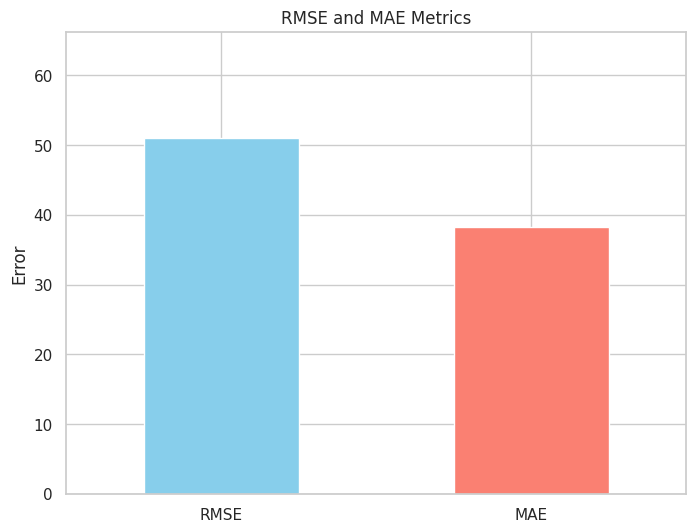

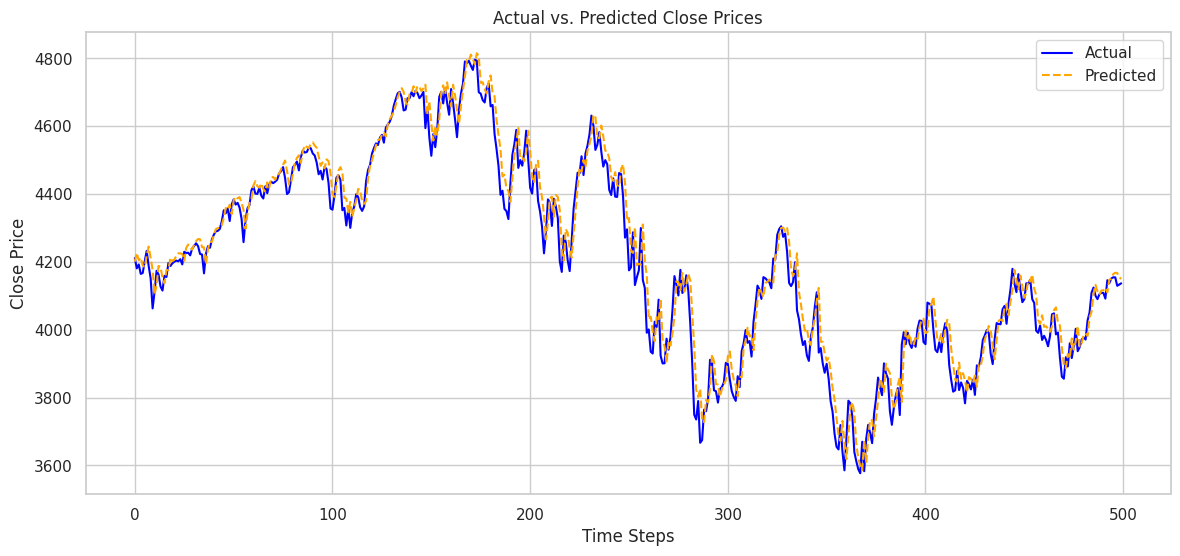

In [42]:
# Visualize the evaluation metrics and predictions
visualize_results(
    final_trainer,
    test_dataset,
    test_data,
    train_data,
    context_length
)

# Compare the Models

In [43]:
def plot_metrics_comparison(metrics_df):
    """
    Plots RMSE and MAE for both models in a grouped bar chart.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing metrics for both models.
    """
    metrics = metrics_df['Metric'].tolist()
    untuned_metrics = metrics_df['Untuned Model'].tolist()
    tuned_metrics = metrics_df['Tuned Model'].tolist()

    x = np.arange(len(metrics))  # label locations
    width = 0.35  # bar width

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, untuned_metrics, width, label='Untuned Metrics', color='skyblue')
    plt.bar(x + width/2, tuned_metrics, width, label='Tuned Metrics', color='salmon')

    # Add labels, title, and custom x-axis tick labels
    plt.ylabel('Error')
    plt.title('Evaluation Metrics Comparison')
    plt.xticks(x, metrics)
    plt.legend()

    # Add value labels on top of the bars
    for i in range(len(metrics)):
        plt.text(x[i] - width/2, untuned_metrics[i], f"{untuned_metrics[i]:.2f}", ha='center', va='bottom')
        plt.text(x[i] + width/2, tuned_metrics[i], f"{tuned_metrics[i]:.2f}", ha='center', va='bottom')

    plt.ylim(0, max(max(untuned_metrics), max(tuned_metrics)) * 1.2)
    plt.show()

In [44]:
def plot_comparison_actual_predicted(dates, actual_values, pred_values_1, pred_values_2, title='Actual vs. Predicted Close Prices'):
    """
    Plots actual versus predicted 'Close' prices for both Transformer models on the same plot.

    Args:
        dates (pd.DatetimeIndex or list-like): Dates corresponding to the actual and predicted values.
        actual_values (np.ndarray): Actual 'Close' prices.
        pred_values_1 (np.ndarray): Predicted 'Close' prices from the first model.
        pred_values_2 (np.ndarray): Predicted 'Close' prices from the second model.
        title (str, optional): Title of the plot. Defaults to 'Actual vs. Predicted Close Prices'.

    Raises:
        AssertionError: If the lengths of the input arrays do not match.
    """
    # Ensure all input arrays have the same length
    assert len(dates) == len(actual) == len(pred_values_1) == len(pred_values_2), \
        "All input arrays must have the same length."

    plt.figure(figsize=(14, 7))

    # Plot Actual Close Prices
    plt.plot(dates, actual, label='Actual Close', color='blue', linestyle='-')

    # Plot predictions from the first model
    plt.plot(dates, pred_values_1, label='Predicted Close (Untuned Model)', color='red', linestyle='--')

    # Plot predictions from the second model
    plt.plot(dates, pred_values_2, label='Predicted Close (Tuned Model)', color='green', linestyle='-.')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(title)

    # Adding legend
    plt.legend()

    # Adding grid for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

In [45]:
def compare_model_results(trainer, final_trainer, test_dataset, test_data, train_data, context_length):
    """
    Compare the results of two trained models.

    Args:
        trainer (Trainer): Untuned Trainer instance.
        final_trainer (Trainer): Tuned Trainer instance.
        test_dataset (ForecastDFDataset): Testing dataset.
        test_data (pd.DataFrame): Testing data.
        train_data (pd.DataFrame): Training data.
        context_length (int): Length of the input context.
    """
    # Get trainer predictions
    actual, predicted = get_predictions(
        trainer,
        test_dataset,
        test_data,
        train_data,
        context_length=context_length
    )

    # Get final_trainer predictions
    final_actual, final_predicted = get_predictions(
        final_trainer,
        test_dataset,
        test_data,
        train_data,
        context_length=context_length
    )

    # Compute metrics with trainer predictions
    trainer_metrics = compute_evaluation_metrics(actual, predicted)
    trainer_metrics_df = create_metrics_df(trainer_metrics)

    # Compute metrics with final_trainer predictions
    final_trainer_metrics = compute_evaluation_metrics(final_actual, final_predicted)
    final_trainer_metrics_df = create_metrics_df(final_trainer_metrics)

    # Combine the DataFrames
    metrics_combined = pd.DataFrame({
        'Metric': ['RMSE', 'MAE'],
        'Untuned Model': [trainer_metrics_df['RMSE'][0], trainer_metrics_df['MAE'][0]],
        'Tuned Model': [final_trainer_metrics_df['RMSE'][0], final_trainer_metrics_df['MAE'][0]]
    })

    print("Evaluation Metrics Comparison:")
    display(metrics_combined)
    print("\n")

    # Plot the metrics comparison
    plot_metrics_comparison(metrics_combined)
    print("\n")

    # Get the test data dates
    dates = test_data['Date'][context_length:].reset_index(drop=True)

    # Plot the actual versus predicted comparison
    plot_comparison_actual_predicted(dates, actual, predicted, final_predicted)

Evaluation Metrics Comparison:


,Metric,Untuned Model,Tuned Model
0,RMSE,51.911061,50.973717
1,MAE,38.702189,38.311337


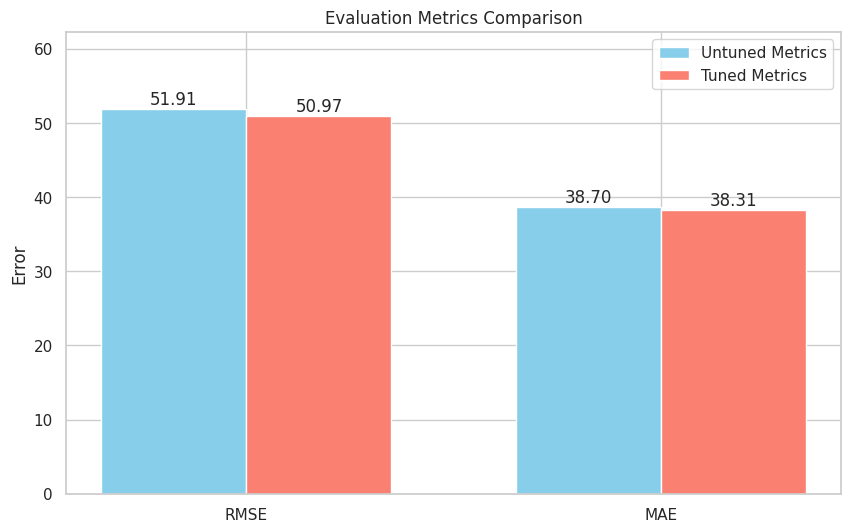

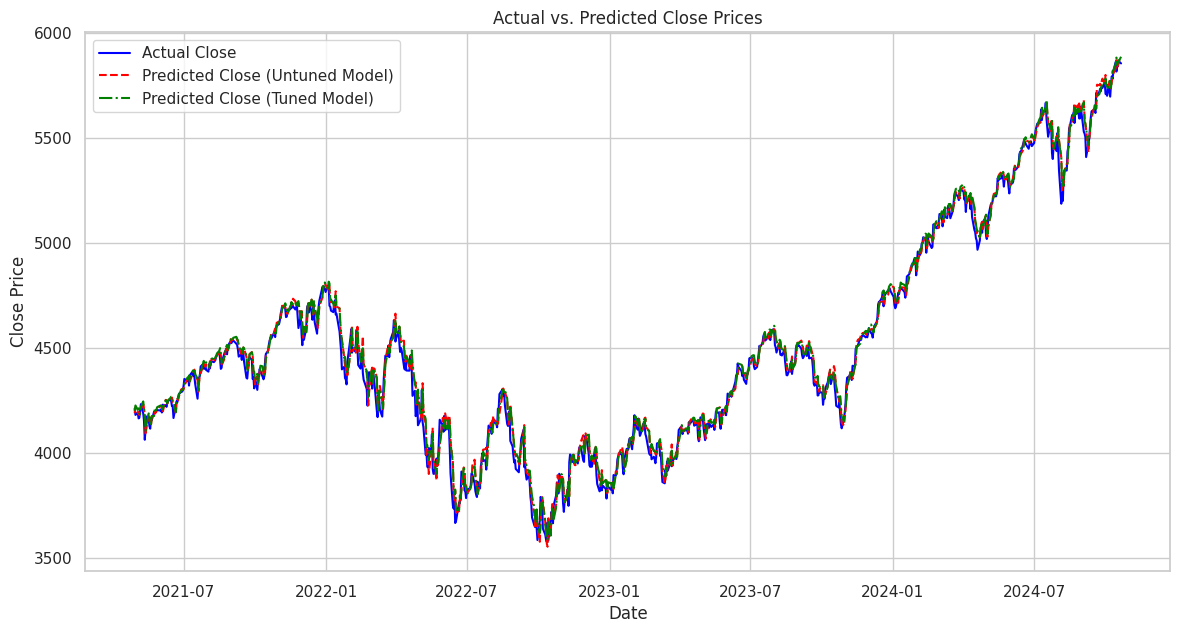

In [46]:
# Compare the models
compare_model_results(
    trainer,
    final_trainer,
    test_dataset,
    test_data,
    train_data,
    context_length
)